## Configuration

In [1]:
import sys
import os

model_name = 'exp-7-v2.pkl'
SEED = 42
VAL_PCT = 0.2
INFER = True

DEBUG = True
VIZ = True

GRADIENT = os.path.exists('train')
KAGGLE = os.path.exists('../input')

if KAGGLE:
    !mkdir -p uwmadisonutils
    !cp ../input/uw-madison-models/*.py uwmadisonutils/
    !cp -r ../input/pytorch-segmentation-models-lib/ ./
    !pip install -q ./pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
    !pip install -q ./pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
    !pip install -q ./pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
    !pip install -q ./pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl


if KAGGLE:
    sys.path.insert(0, '../input/uwmadisonutils/')
    data_path = '../input/uw-madison-gi-tract-image-segmentation/'
    model_name = '../input/uw-madison-models/' + model_name
    
elif GRADIENT:
    sys.path.insert(0, 'uwmadisonutils/')
    data_path = ''
    model_name = 'uwmadisonutils/' + model_name 

from uwmadisonutils.utilities import *

## Libraries and Data

In [2]:
path = Path(data_path+'train')
test_path = Path(data_path+'test')

train = pd.read_csv(data_path+'train.csv', low_memory=False)
sample_submission = pd.read_csv(data_path+'sample_submission.csv', low_memory=False).rename(columns={'predicted': 'segmentation'})

train_path = Path(data_path+'train')
test_path = Path(data_path+'test')

train_fnames = get_image_files(train_path)
test_fnames = get_image_files(test_path)

## Prepare Data

In [3]:
# if sample_submission.shape[0] > 0: 
#     test = sample_submission.copy()
# else:
#     test_fnames = train_fnames
#     test_path = train_path
#     test = train.copy()
#     test = test.sample(frac=1.0, random_state=SEED)

# test = get_custom_df(test, test_fnames, str(test_path), channels=5)
# train = get_custom_df(train, train_fnames, str(train_path), channels=5)

In [4]:
# if DEBUG:
#     test = test.iloc[:1000]
#     test_fnames = test_fnames[:1000]

## Learner

# Experiments

## Compare models

In [61]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [62]:
# train = train.sample(frac=0.1).reset_index(drop=True)

In [63]:
dls, dev = get_5C_25D_dls(train, channels=3, up_size=(320, 384), fold=0,
                          crop=0.6, val_crop=1.0, resize=1.0, bs=32, show=False, aug='alb',
                          tfms_kwargs=dict(train=get_train_aug, test=get_test_aug))

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [64]:
def get_tta_preds(learn, b, deep_supervision):
    b_preds1 = learn.model(b)
    b_preds2 = learn.model(b.flip_lr())

    if deep_supervision: 
        b_preds1 = b_preds1[-1]
        b_preds2 = b_preds2[-1]
        
    b_preds = (sigmoid(b_preds1) +
               sigmoid(b_preds2.flip_lr()) 
              ) / 2
    
    return b_preds

In [65]:
def inference(learn, dls):
    learn.model = learn.model.cuda()
    preds = torch.zeros((len(dev.query('is_valid')), 3, 320, 384))
    scores = []
    with torch.no_grad():
        for i, b in enumerate(tqdm(dls)):
            inp, targ = b
            b_preds = learn.model(inp)[-1]
            preds[i*len(inp):i*len(inp)+len(inp)] = (sigmoid(b_preds) > 0.5).long()
            scores.extend([dice_coeff_adj(b_preds[i][None,...], targ[i][None,...]) for i in range(len(inp))])
            
        return preds, scores

In [66]:
exp31 = load_learner('uwmadisonutils/exp-31-f0-e99.pkl', cpu=False)
# exp26 = load_learner('uwmadisonutils/exp-26-f0-v1.0.pkl', cpu=False)

In [ ]:
exp31_preds, exp31_scores = inference(exp31, dls.valid)

 86%|████████▌ | 211/246 [06:35<01:05,  1.88s/it]

In [57]:
# exp26_preds, exp26_scores = inference(exp26, dls.valid)

100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


### Worst 10 predictions

In [38]:
valid = dev.query('is_valid').copy().reset_index(drop=True)

In [39]:
valid.loc[:, 'exp31_scores'] = exp31_scores

In [40]:
valid = valid.query('n_segs != 0 & exp31_scores != 0')
valid['index'] = valid.index
valid.shape

(347, 23)

In [41]:
valid = valid.iloc[:10]

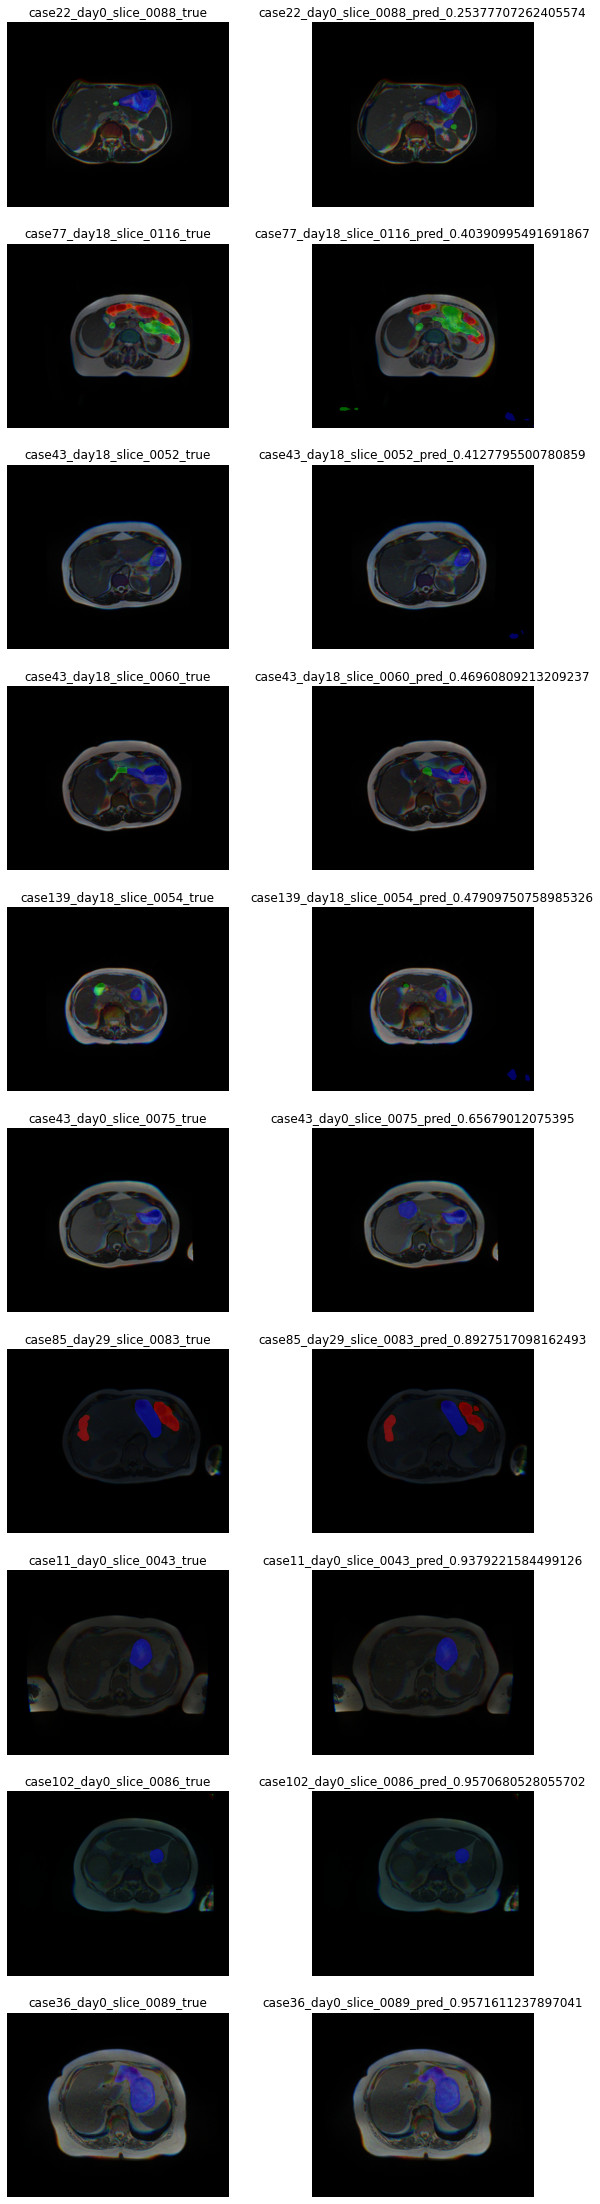

In [60]:
valid = valid.sort_values('exp31_scores')

fig, axes = plt.subplots(len(valid), 2, figsize=(10, len(valid)*4))


for i, (j, row) in enumerate(valid.iterrows()):
    img = get_25D_image(row, up_size=(320, 384))
    targ_mask = get_mask(row, up_size=(320, 384))
    pred_mask = exp31_preds[j]

    show_image(img, ctx=axes[i, 0], title=row['id']+'_true')
    show_image(targ_mask, alpha=0.4, ctx=axes[i, 0])

    show_image(img, ctx=axes[i, 1], title=row['id']+f'_pred_{exp31_scores[j]}')
    show_image(pred_mask, alpha=0.4, ctx=axes[i, 1])

<AxesSubplot:>

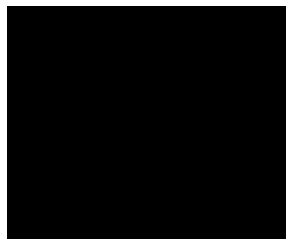

In [46]:
show_image(exp31_preds[-3]*255)

## Visualizing Masks

In [5]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [6]:
dls, dev = get_5C_25D_dls(train, channels=3, up_size=(320, 384), fold=0,
                          crop=0.6, val_crop=1.0, resize=1.0, bs=32, show=False, aug='alb',
                          tfms_kwargs=dict(train=get_train_aug, test=get_test_aug))

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [16]:
model_names = [
    'uwmadisonutils/exp-31-f0-e99.pkl',
    'uwmadisonutils/exp-26-f0-v1.0.pkl',
    'uwmadisonutils/exp-26-f1-v1.0.pkl',
    'uwmadisonutils/exp-26-f2-v1.0.pkl',
    'uwmadisonutils/exp-26-f3-v1.0.pkl',
]

ws = [
    4, 
    1,
    1,
    1,
    1,
]

In [17]:
learns = [load_learner(model_name, cpu=False) for model_name in model_names]

In [34]:
case_ids = 'id: case123_day20_slice_0111  |  id: case123_day22_slice_0108  |  id: case123_day0_slice_0113  |  id: case123_day0_slice_0062  |  id: case123_day22_slice_0088  |  id: case123_day20_slice_0105  |  id: case123_day0_slice_0087  |  id: case123_day20_slice_0084  |  id: case123_day22_slice_0115  |  id: case123_day0_slice_0086  |  id: case123_day0_slice_0096  |  id: case123_day0_slice_0076  |'

In [35]:
case_ids = case_ids.replace('id: ', '').replace('  |  ', ' ').replace('  |', '').split(' ')

In [36]:
sort_cases = {}
i = 0
for case_id in case_ids:
    print(case_id, i)
    if case_id not in sort_cases:
        sort_cases[case_id] = i
        i += 1

case123_day20_slice_0111 0
case123_day22_slice_0108 1
case123_day0_slice_0113 2
case123_day0_slice_0062 3
case123_day22_slice_0088 4
case123_day20_slice_0105 5
case123_day0_slice_0087 6
case123_day20_slice_0084 7
case123_day22_slice_0115 8
case123_day0_slice_0086 9
case123_day0_slice_0096 10
case123_day0_slice_0076 11


In [37]:
sort_cases

{'case123_day20_slice_0111': 0,
 'case123_day22_slice_0108': 1,
 'case123_day0_slice_0113': 2,
 'case123_day0_slice_0062': 3,
 'case123_day22_slice_0088': 4,
 'case123_day20_slice_0105': 5,
 'case123_day0_slice_0087': 6,
 'case123_day20_slice_0084': 7,
 'case123_day22_slice_0115': 8,
 'case123_day0_slice_0086': 9,
 'case123_day0_slice_0096': 10,
 'case123_day0_slice_0076': 11}

In [38]:
dev_slices = dev.query('id in @case_ids').copy()

dev_slices.loc[:, 'sort_cases'] = dev_slices.id.map(sort_cases)

dev_slices = dev_slices.sort_values('sort_cases')

In [39]:
dev_slices_dl = dls.test_dl(dev_slices, bs=len(case_ids), shuffle=False).to('cuda')

In [40]:
def get_tta_preds(learn, b, deep_supervision):
    b_preds1 = learn.model(b)
    b_preds2 = learn.model(b.flip_lr())

    if deep_supervision: 
        b_preds1 = b_preds1[-1]
        b_preds2 = b_preds2[-1]
        
    b_preds = (sigmoid(b_preds1) +
               sigmoid(b_preds2.flip_lr()) 
              ) / 2
    
    return b_preds

In [45]:
from fastai.vision.all import sigmoid as fastsigmoid

def get_tta_preds(learn, b, deep_supervision):
    b_preds1 = learn.model(b)
    
    b_preds2 = learn.model(torch.flip(b, dims=[3]))    
    
    if deep_supervision: 
        b_preds1 = b_preds1[-1]
        b_preds2 = b_preds2[-1]

    b_preds = (fastsigmoid(b_preds1) +
               fastsigmoid(torch.flip(b_preds2, dims=[3]))                 
              ) / 2
    
    return b_preds

In [46]:
with torch.no_grad():
    for i, b in enumerate(tqdm(dev_slices_dl)):
        b_preds = None
        
        for j, learn in enumerate(learns):                    
            if torch.is_tensor(b_preds):
                b_preds += ws[j] * get_tta_preds(learn, b, True)
            else:
                b_preds = ws[j] * get_tta_preds(learn, b, True)
                
        b_preds = b_preds / sum(ws)

100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


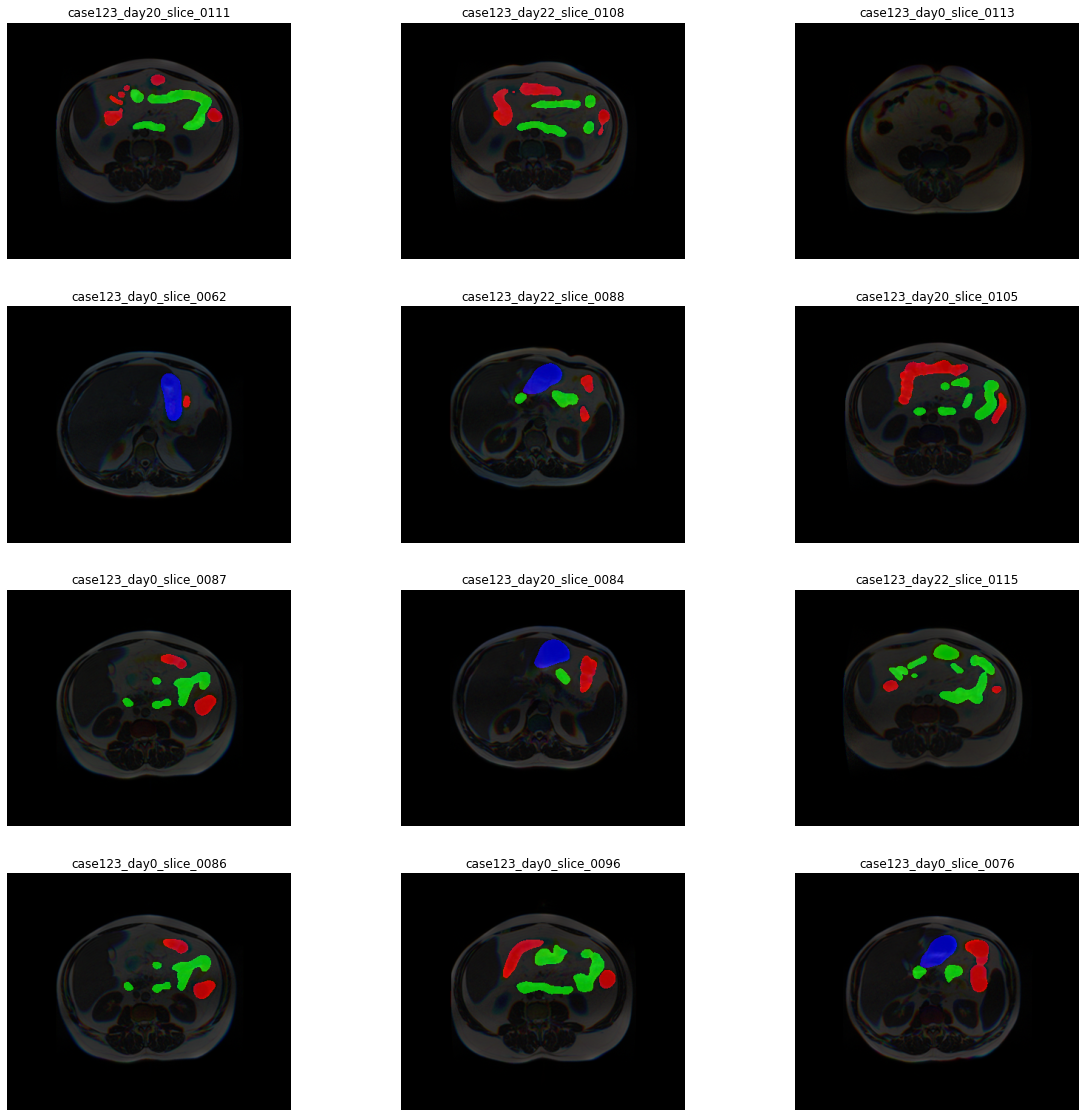

In [47]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

axes = axes.flatten()

for i, case_id in enumerate(dev_slices.id):
    img = get_25D_image(dev_slices.query('id == @case_id').iloc[0], up_size=(320, 384))
    mask = ((b_preds[i] > 0.6).long() * 255)
    
    show_image(img ,ctx=axes[i], title=case_id)
    show_image(mask, cmap='Spectral_r', alpha=0.7, ctx=axes[i], title=case_id)

In [129]:
intrp = SegmentationInterpretation(learn, dls, dice_coeff_adj, act=sigmoid)

In [131]:
intrp.top_losses(4)

AttributeError: 'function' object has no attribute 'topk'

## Attention in Unet decoder

In [ ]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout(),
                albumentations.Resize(height=resize, width=resize, always_apply=True)
            ])

In [10]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [8]:
import wandb as wb
from fastai.callback.wandb import WandbCallback

In [12]:
def train_model(encoder, unet_kwargs,  group='unet++-tests', epochs=12, log=True):    
    
    if log: wb.init(project="uw-madison models", group=group, name=f'{encoder}-scse')
    
    tfms_kwargs = dict(train=get_train_aug, test=get_test_aug) 
    
    dls, dev = get_5C_25D_dls(train, channels=3, up_size=(320, 384), fold=0,
                              crop=0.8, val_crop=0.8, resize=0.25, bs=64, show=False, aug='alb',
                              tfms_kwargs=tfms_kwargs, sample_empty=True, empty_frac=0.5)
    
    model = UNetPlusPlus(encoder, in_channels=3, classes=3, pretrained=True, **unet_kwargs)
    loss_func = deep_supervision_loss
    metrics = [dice_coeff_deep, hd_dist_deep, custom_metric_deep]
    splitter = unetplusplus_splitter
    
    cbs=[GradientAccumulation(64)]
    
    if log: cbs += [WandbCallback(log_preds=False)]
        
    learn = get_custom_learner(dls, model, loss_func, splitter, metrics, cbs=cbs)
    
    learn.unfreeze()
    learn.fit_one_cycle(epochs, 1e-2)

In [ ]:
train_model('regnety_160', dict(attention_type='scse'), group='encoder-tests', epochs=20, log=True)

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▇▇█
lr_1,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▇▇█
mom_0,███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁
mom_1,███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁
raw_loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,3.871701,3.752147,0.014152,0.091645,0.060648,05:11
1,3.017421,2.908414,0.001057,0.209024,0.125837,05:07
2,2.453525,2.373794,0.000000,0.963071,0.577842,05:02
3,2.162967,2.109874,0.088969,0.739150,0.479077,05:04
4,1.971968,1.922056,0.267707,0.633669,0.487284,05:01
5,1.828637,1.766977,0.320094,0.637020,0.510250,05:02
6,1.709138,1.654786,0.335605,0.679436,0.541904,05:17
7,1.639000,1.552261,0.370328,0.781418,0.616982,05:13
8,1.606478,1.523125,0.371863,0.735322,0.589938,05:19
9,1.582438,1.496301,0.372196,0.731235,0.587619,05:14


## Testing configurations

In [5]:
def old_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout(),
                albumentations.Resize(height=resize, width=resize, always_apply=True)
            ])


def light_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomResizedCrop(height=resize, width=resize, always_apply=True),
                albumentations.OneOf([
                    albumentations.Transpose(),
                    albumentations.VerticalFlip(),
                    albumentations.HorizontalFlip(),
                    albumentations.RandomRotate90(),
                    albumentations.NoOp()
                ], p=p),
        
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                ], p=p),
            ])

def medium_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomResizedCrop(height=resize, width=resize, always_apply=True),
                albumentations.OneOf([
                    albumentations.Transpose(),
                    albumentations.VerticalFlip(),
                    albumentations.HorizontalFlip(),
                    albumentations.RandomRotate90(),
                    albumentations.NoOp()
                ], p=p),
        
                albumentations.OneOf([
                    albumentations.CoarseDropout(max_holes=16, max_height=16, max_width=16),
                    albumentations.NoOp()
                ], p=p),
        
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                ], p=p),
                
            ])


def heavy_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomResizedCrop(height=resize, width=resize, always_apply=True),
                albumentations.OneOf([
                    albumentations.Transpose(),
                    albumentations.VerticalFlip(),
                    albumentations.HorizontalFlip(),
                    albumentations.RandomRotate90(),
                    albumentations.NoOp()
                ], p=p),
        
                albumentations.OneOf([
                    albumentations.CoarseDropout(),
                    albumentations.NoOp()
                ], p=p),
        
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                ], p=p),
        
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                ], p=p),
                albumentations.ShiftScaleRotate(),
            ])

## Testing encoders

In [6]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout(),
                albumentations.Resize(height=resize, width=resize, always_apply=True)
            ])

In [7]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [8]:
import wandb as wb
from fastai.callback.wandb import WandbCallback

In [9]:
def train_model(encoder,  group='unet++-tests', epochs=12, log=True):    
    
    if log: wb.init(project="uw-madison models", group=group, name=f'{encoder}')
    
    tfms_kwargs = dict(train=get_train_aug, test=get_test_aug) 
    
    dls, dev = get_5C_25D_dls(train, channels=3, up_size=(320, 384), fold=0,
                              crop=0.8, val_crop=0.8, resize=0.25, bs=64, show=False, aug='alb',
                              tfms_kwargs=tfms_kwargs, sample_empty=True, empty_frac=0.5)
    
    model = UNetPlusPlus(encoder, in_channels=3, classes=3, pretrained=True)
    loss_func = deep_supervision_loss
    metrics = [dice_coeff_deep, hd_dist_deep, custom_metric_deep]
    splitter = unetplusplus_splitter
    
    cbs=[GradientAccumulation(64)]
    
    if log: cbs += [WandbCallback(log_preds=False)]
        
    learn = get_custom_learner(dls, model, loss_func, splitter, metrics, cbs=cbs)
    
    learn.unfreeze()
    learn.fit_one_cycle(epochs, 1e-2)

In [12]:
train_model('tf_efficientnet_b5', group='encoder-tests', epochs=20, log=True)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.882516,1.776865,0.113317,0.614713,0.414155,02:51
1,1.483285,1.298471,0.353106,0.772335,0.604643,02:51
2,1.307220,1.151423,0.406007,0.724622,0.597176,02:50
3,1.197284,1.232567,0.347848,0.693005,0.554942,02:52
4,1.117018,1.012526,0.467184,0.787691,0.659488,02:52
5,1.045879,0.941319,0.536055,0.779777,0.682288,02:54
6,0.983440,0.957159,0.506853,0.752283,0.654111,03:07
7,0.921057,0.893329,0.530213,0.827742,0.708730,02:52
8,0.907676,0.892688,0.550693,0.849766,0.730137,02:54
9,0.869911,0.863796,0.554404,0.851445,0.732628,02:54


In [10]:
configs1 = [
    # 'tf_efficientnet_b5',
    # 'res2net50_26w_8s',
    # 'resnet101',
    # 'resnext101_32x4d',
    # 'efficientnet_b6',
    # 'regnety_120'
]

configs2 = [
    # 'resnest200e',
    'efficientnet_b7',
    'regnety_160'
]

In [11]:
for encoder in configs1+configs2:
    train_model(encoder, group='encoder-tests', epochs=20, log=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
No pretrained weights exist for this model. Using random initialization.


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.874736,1.762577,0.055902,0.861865,0.539479,04:05
1,1.469061,1.280311,0.356360,0.795900,0.620084,04:00
2,1.271778,1.148858,0.403422,0.729282,0.598938,04:05
3,1.178940,1.187429,0.416194,0.731390,0.605312,04:01
4,1.077814,0.967037,0.495497,0.799357,0.677813,04:05
5,1.013486,0.958056,0.528177,0.822639,0.704854,04:08
6,0.942140,0.945411,0.509922,0.765529,0.663286,04:06
7,0.886118,0.893533,0.525999,0.848869,0.719721,03:46
8,0.858865,0.874138,0.556207,0.841027,0.727099,03:43
9,0.823604,0.846047,0.549571,0.852480,0.731316,03:42


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



custom_metric_deep,▁▃▃▃▅▆▅▇▇▇▇▇█▇▇█████
dice_coeff_deep,▁▅▅▆▇▇▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,█▄▁▁▄▆▃▇▆▇▆▇▇▇▇█████
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▅▅▅▄▄▃▃▃▃▂▃▂▂▂▃▂▂▂▂▃▂▂▂▁▂▁▂▂▂▁▂▂▂▁▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://dl.fbaipublicfiles.com/deit/regnety_160-a5fe301d.pth" to /root/.cache/torch/hub/checkpoints/regnety_160-a5fe301d.pth


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.644416,1.521459,0.266964,0.580057,0.454820,02:56
1,1.243265,1.202399,0.362126,0.879045,0.672277,02:57
2,1.159834,1.109289,0.430609,0.857742,0.686889,02:55
3,1.095098,1.185268,0.436300,0.807943,0.659286,02:54
4,1.044711,1.061752,0.432055,0.892983,0.708612,02:57
5,1.006881,1.146767,0.449424,0.694030,0.596187,02:56
6,0.943282,1.063222,0.489125,0.809552,0.681381,02:55
7,0.889409,1.081987,0.434168,0.838916,0.677017,02:42
8,0.881177,0.916167,0.498223,0.880361,0.727506,03:02
9,0.850773,0.939990,0.489617,0.889929,0.729804,03:17


In [12]:
configs3 = [
    'regnety_320',
    'regnetx_160',
    'regnetx_320'
]

In [ ]:
for encoder in configs3:
    train_model(encoder, group='encoder-tests', epochs=20, log=True)

custom_metric_deep,▁▆▆▅▇▄▆▆▇▇▇█▇███████
dice_coeff_deep,▁▃▄▄▄▅▅▄▅▅▇▇▇███████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▁█▇▆█▄▆▇██▇███▇▇████
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▄▅▄▄▃▃▃▂▃▂▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▂▂▂▂▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_320-ba464b29.pth" to /root/.cache/torch/hub/checkpoints/regnety_320-ba464b29.pth


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.713125,1.610548,0.272410,0.661637,0.505946,02:55
1,1.296900,1.336883,0.339559,0.742873,0.581548,02:54
2,1.198721,1.085062,0.423289,0.815178,0.658423,02:56
3,1.144487,1.095651,0.448836,0.835713,0.680962,03:02
4,1.073605,1.065292,0.453383,0.863869,0.699675,03:03
5,1.025241,0.920116,0.536490,0.831155,0.713289,03:06
6,0.960376,0.935257,0.506108,0.806180,0.686151,03:24
7,0.913808,0.870034,0.547455,0.822211,0.712309,03:29
8,0.905279,1.008931,0.476363,0.911525,0.737460,03:07
9,0.869639,1.289436,0.400726,0.726639,0.596274,03:00


custom_metric_deep,▁▃▅▆▆▇▆▇▇▃▇█████████
dice_coeff_deep,▁▂▄▅▅▆▆▇▅▄▇▇▇███████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▁▃▅▆▇▆▅▅█▃▇▇▇▆▆▇▇▇▇▇
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▃▂▃▂▂▃▂▂▂▁▁▂▂▂▂▁▂▂▂▂▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_160-c98c4112.pth" to /root/.cache/torch/hub/checkpoints/regnetx_160-c98c4112.pth


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.657695,1.487883,0.372366,0.718750,0.580197,02:44
1,1.309608,1.161107,0.388368,0.774604,0.620110,02:42
2,1.224270,1.127506,0.410215,0.802864,0.645805,02:41
3,1.161495,1.257318,0.403047,0.719493,0.592915,02:39
4,1.107066,1.029021,0.435580,0.701531,0.595151,02:38
5,1.049471,0.960159,0.546523,0.844316,0.725199,02:39
6,0.989563,0.906280,0.525730,0.805868,0.693813,02:41
7,0.935504,0.918519,0.521485,0.765003,0.667596,02:40
8,0.924311,0.879064,0.536594,0.861861,0.731754,02:37
9,0.893007,0.928339,0.523500,0.819094,0.700857,02:38


custom_metric_deep,▁▂▃▁▂▆▅▄▇▅▇▇▇█▇█████
dice_coeff_deep,▁▁▂▂▃▆▅▅▆▅▇▆▇█▇█████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▂▄▅▂▁▇▅▄█▆█▇██▇█████
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▃▂▂▃▂▂▂▁▁▂▁▂▂▁▂▂▁▂▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_320-8ea38b93.pth" to /root/.cache/torch/hub/checkpoints/regnetx_320-8ea38b93.pth


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.633239,1.373762,0.291064,0.768266,0.577385,02:40
1,1.324785,1.220947,0.388221,0.780787,0.623761,02:41
2,1.230594,1.163604,0.406070,0.696118,0.580099,02:44
3,1.172110,1.190007,0.392409,0.834431,0.657623,02:45
4,1.107444,1.330480,0.429374,0.742068,0.616991,02:52
5,1.058750,1.016610,0.490496,0.743558,0.642333,02:51
6,0.998759,1.028849,0.502660,0.796032,0.678683,02:54
7,0.941940,0.907408,0.517939,0.753380,0.659203,02:56
8,0.936936,0.862814,0.563005,0.836499,0.727102,02:56
9,0.904898,0.883072,0.549661,0.817658,0.710459,02:57


## Unet++ fastai augmentations

### test 1

In [5]:
import wandb
from fastai.callback.wandb import WandbCallback

In [6]:
train_df = get_custom_df(train, train_fnames, str(train_path), channels=3, stride=2)

In [7]:
def deep_supervision_loss(inp, targ):
    loss = 0
    loss_func = ComboLoss(ws=[2, 1, 0])
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

In [8]:
dls, dev = get_5C_25D_dls(train_df, channels=3, up_size=(320, 384), fold=0,
                              crop=0.8, val_crop=1.0, resize=0.5, bs=64, show=False,
                              tfms_kwargs=dict())

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [10]:
def train_model(encoder, tfms_kwargs, version, group='unet++-tests', epochs=12, log=True):    
    
    if log: wandb.init(project="uw-madison models", group=group, name=f'{encoder}-{version}')
    
    dls, dev = get_5C_25D_dls(train_df, channels=3, up_size=(320, 384), fold=0,
                              crop=0.8, val_crop=1.0, resize=0.5, bs=64, show=False,
                              tfms_kwargs=tfms_kwargs)
    
    model = UNetPlusPlus(encoder, in_channels=3, classes=3, pretrained=False)
    loss_func = deep_supervision_loss
    metrics = custom_metric_deep
    splitter = unetplusplus_splitter

        
    learn = get_custom_learner(dls, model, loss_func, splitter, metrics, 
                               cbs=[WandbCallback(log_preds=False, model_name=f'{encoder}-{version}'),
                                    GradientAccumulation(64)])
    
    learn.unfreeze()
    learn.fit_one_cycle(epochs, 1e-2)

In [11]:
configs = [
    ('efficientnet_b0', 'v0', dict(mult=1.2, max_lighting=0.6, flip_vert=True)),
    ('efficientnet_b0', 'v1', dict(mult=1.2, max_lighting=0.4, flip_vert=True)),
    ('efficientnet_b0', 'v2', dict(mult=1.2, max_lighting=0.2, flip_vert=True)),
    ('efficientnet_b0', 'v3', dict(mult=1.2, max_lighting=0.6, flip_vert=False)),
    ('efficientnet_b0', 'v4', dict(mult=1.2, max_lighting=0.4, flip_vert=False)),
    ('efficientnet_b0', 'v5', dict(mult=1.2, max_lighting=0.2, flip_vert=False)),
]

In [ ]:
for encoder, version, tfms_kwargs in configs:
    train_model(encoder, tfms_kwargs, version)

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,custom_metric_deep,time
0,1.663268,1.524775,0.442863,02:52
1,1.335644,1.124642,0.616853,02:47
2,1.121297,1.059172,0.655459,02:48
3,1.007567,1.273067,0.639197,02:47
4,0.909170,0.955579,0.678286,02:46
5,0.845043,1.052530,0.716137,02:46
6,0.793148,0.760332,0.744633,02:46
7,0.728137,0.732494,0.726893,02:46
8,0.692334,0.745875,0.749049,02:46
9,0.662813,0.722064,0.760446,02:46


custom_metric_deep,▁▆▃▆▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▇▆▅▄▄▄▃▃▃▄▂▄▄▃▃▃▁▃▂▂▂▂▂▂▃▁▂▁▂▁▁▁▁▂▂▁▂▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,custom_metric_deep,time
0,1.534138,1.560593,0.437581,02:47
1,1.172755,1.720124,0.474050,02:47
2,0.978900,1.149892,0.591739,02:47
3,0.873915,0.906428,0.691941,02:47
4,0.784755,0.859173,0.732346,02:47
5,0.744965,0.848609,0.718428,02:48
6,0.697215,1.015447,0.705895,02:48
7,0.625697,0.708573,0.747899,02:48
8,0.607877,0.706968,0.754527,02:49
9,0.570687,0.658958,0.765006,02:48


custom_metric_deep,▁▂▄▆▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▇▆▄▄▄▄▃▃▃▄▃▃▄▂▂▃▂▂▂▂▂▂▂▂▃▁▂▂▂▂▁▁▁▂▂▁▂▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,custom_metric_deep,time
0,1.555585,1.539144,0.466591,02:47
1,1.174960,1.203320,0.625291,02:48
2,0.971849,0.994339,0.679795,02:48
3,0.880243,0.991212,0.696346,02:47
4,0.771035,1.068398,0.674408,02:48
5,0.739635,0.963951,0.713520,02:54
6,0.679532,0.779553,0.744462,02:48
7,0.622265,0.723305,0.744415,02:48
8,0.597688,0.721504,0.756423,02:47
9,0.566306,0.730905,0.750445,02:47


custom_metric_deep,▁▅▆▆▆▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▇▆▅▄▅▄▃▃▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,custom_metric_deep,time
0,1.526044,1.591796,0.450895,02:47
1,1.065842,1.149871,0.668598,02:47
2,0.902661,1.033998,0.699144,02:47
3,0.794162,1.011258,0.694007,02:48
4,0.721003,1.011324,0.664051,02:47
5,0.670561,0.871809,0.727560,02:46
6,0.629571,0.811051,0.741675,02:47


### test 2

In [5]:
import wandb
from fastai.callback.wandb import WandbCallback

In [6]:
train_df = get_custom_df(train, train_fnames, str(train_path), channels=3, stride=2)

In [7]:
def deep_supervision_loss(inp, targ):
    loss = 0
    loss_func = ComboLoss(ws=[2, 3, 1])
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

In [8]:
def get_train_aug_new(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
            # albumentations.OneOf([
            #     albumentations.RandomSizedCrop(min_max_height=(192, 256), height=crop_size, width=crop_size, p=0.5),
            #     albumentations.PadIfNeeded(min_height=crop_size, min_width=crop_size, p=0.5)
            # ], p=1),
            albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            albumentations.VerticalFlip(p=0.5),
            # albumentations.RandomRotate90(p=0.5*p),
            albumentations.OneOf([
                albumentations.GridDistortion(p=0.5),
                albumentations.ElasticTransform(p=0.5),
                albumentations.OpticalDistortion(p=1.0)
            ], p=0.8),
            albumentations.CLAHE(p=0.8),
            albumentations.RandomBrightnessContrast(brightness_limit=0.3, p=0.8),    
            albumentations.RandomGamma(p=0.8),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.8*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.5*p),
            albumentations.GaussNoise(p=0.5),
            #     albumentations.OneOf([
            #         albumentations.OpticalDistortion(p=0.3*p),
            #         albumentations.GridDistortion(p=0.1*p),
            #         albumentations.PiecewiseAffine(p=0.3*p),
            #     ], p=0.2*p),
            #     albumentations.OneOf([
            #         albumentations.Sharpen(p=0.2*p),
            #         albumentations.Emboss(p=0.2*p),
            #         albumentations.RandomBrightnessContrast(p=0.2*p),
            #     ]),
            albumentations.Resize(height=resize, width=resize, always_apply=True)
            ])


def get_train_aug_new2(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
            # albumentations.OneOf([
            #     albumentations.RandomSizedCrop(min_max_height=(192, 256), height=crop_size, width=crop_size, p=0.5),
            #     albumentations.PadIfNeeded(min_height=crop_size, min_width=crop_size, p=0.5)
            # ], p=1),
            albumentations.RandomSizedCrop(min_max_height=(192, 256), height=crop_size, width=crop_size, p=1.0),
            # albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            albumentations.VerticalFlip(p=0.5),
            # albumentations.RandomRotate90(p=0.5*p),
            albumentations.OneOf([
                albumentations.GridDistortion(p=0.5),
                albumentations.ElasticTransform(p=0.5),
                albumentations.OpticalDistortion(p=1.0)
            ], p=0.8),
            albumentations.CLAHE(p=0.8),
            albumentations.RandomBrightnessContrast(brightness_limit=0.3, p=0.8),    
            albumentations.RandomGamma(p=0.8),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.8*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.5*p),
            albumentations.GaussNoise(p=0.5),
            #     albumentations.OneOf([
            #         albumentations.OpticalDistortion(p=0.3*p),
            #         albumentations.GridDistortion(p=0.1*p),
            #         albumentations.PiecewiseAffine(p=0.3*p),
            #     ], p=0.2*p),
            #     albumentations.OneOf([
            #         albumentations.Sharpen(p=0.2*p),
            #         albumentations.Emboss(p=0.2*p),
            #         albumentations.RandomBrightnessContrast(p=0.2*p),
            #     ]),
            albumentations.Resize(height=resize, width=resize, always_apply=True)
            ])

In [9]:
def train_model(encoder, tfms_kwargs, empty_kwargs, version,  group='unet++-tests', epochs=12, log=True):    
    
    if log: wandb.init(project="uw-madison models", group=group, name=f'{encoder}-{version}')
    
    dls, dev = get_5C_25D_dls(train_df, channels=3, up_size=(320, 384), fold=0,
                              crop=0.6, val_crop=0.6, resize=0.5, bs=64, show=False,
                              tfms_kwargs=tfms_kwargs, **empty_kwargs)
    
    model = UNetPlusPlus(encoder, in_channels=3, classes=3, pretrained=False)
    loss_func = deep_supervision_loss
    metrics = [dice_coeff_deep, hd_dist_deep, custom_metric_deep]
    splitter = unetplusplus_splitter

        
    learn = get_custom_learner(dls, model, loss_func, splitter, metrics, 
                               cbs=[WandbCallback(log_preds=False, model_name=f'{encoder}-{version}'),
                                    GradientAccumulation(64)])
    
    learn.unfreeze()
    learn.fit_one_cycle(epochs, 1e-2)

In [10]:
configs = [
    ('efficientnet_b0', 'v0', dict(train=get_train_aug_new, test=get_test_aug), dict(aug='albu', aug_p=1.0, sample_empty=True, empty_frac=0.5)),
    ('efficientnet_b0', 'v1', dict(train=get_train_aug_new2, test=get_test_aug), dict(aug='albu', aug_p=1.0, sample_empty=True, empty_frac=0.5)),
    ('efficientnet_b0', 'v4', dict(train=get_train_aug, test=get_test_aug), dict(aug='albu', sample_empty=True, empty_frac=0.5)),
    ('efficientnet_b0', 'v2', dict(train=get_train_aug, test=get_test_aug), dict(aug='albu', sample_empty=True, empty_frac=0.1)),
    ('efficientnet_b0', 'v3', dict(train=get_train_aug, test=get_test_aug), dict(aug='albu', sample_empty=True, empty_frac=0.3)),
    ('efficientnet_b0', 'v5', dict(train=get_train_aug, test=get_test_aug), dict(aug='albu', sample_empty=False)),
]

In [12]:
for encoder, version, tfms_kwargs, empty_kwargs in configs:
    train_model(encoder, tfms_kwargs, empty_kwargs, version, group='unet++-29-tests', epochs=6)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,2.000994,1.909960,0.164059,0.694508,0.482328,03:50
1,1.633774,1.458587,0.365828,0.643012,0.532138,03:50
2,1.433401,1.430647,0.382482,0.742822,0.598686,03:45
3,1.308335,1.143195,0.494399,0.718405,0.628803,03:47
4,1.190354,1.064464,0.538036,0.759395,0.670852,03:48
5,1.145041,1.032411,0.543431,0.745742,0.664818,03:49


custom_metric_deep,▁▃▅▆██
dice_coeff_deep,▁▅▅▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▄▁▇▆█▇
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▅▅▅▅▅▄▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▂▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.923955,1.858626,0.175715,0.510867,0.376806,03:51
1,1.569810,1.512828,0.321274,0.535117,0.449580,03:55
2,1.379223,1.254186,0.429484,0.651340,0.562597,03:54
3,1.229613,1.091763,0.517049,0.735317,0.648010,03:49
4,1.146914,1.031440,0.548714,0.755869,0.673007,03:52
5,1.102572,1.006983,0.558427,0.749448,0.673040,03:49


custom_metric_deep,▁▃▅▇██
dice_coeff_deep,▁▄▆▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▁▂▅▇██
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▅▅▅▅▄▄▄▄▃▄▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▃▂▁▂▂▂▂▂▁▂▂▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.834677,1.721990,0.276760,0.540801,0.435185,03:51
1,1.441166,1.317000,0.409252,0.671685,0.566712,03:53
2,1.261333,1.065115,0.505131,0.722381,0.635481,03:52
3,1.130823,0.961658,0.549288,0.796034,0.697335,03:52
4,1.033648,0.903453,0.590123,0.791907,0.711194,03:51
5,0.998699,0.871510,0.602531,0.787514,0.713521,03:52


custom_metric_deep,▁▄▆███
dice_coeff_deep,▁▄▆▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▁▅▆███
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▃▂▁▂▂▂▁▁▁▂▁▂▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.968729,2.046543,0.108098,0.418880,0.294567,02:57
1,1.576493,1.518026,0.326680,0.501581,0.431620,02:54
2,1.346262,1.266028,0.403724,0.589004,0.514892,02:54
3,1.202054,1.019715,0.527488,0.708836,0.636297,02:55
4,1.117536,0.978456,0.548543,0.719270,0.650979,02:58
5,1.084644,0.965152,0.558474,0.723624,0.657564,02:52


custom_metric_deep,▁▄▅███
dice_coeff_deep,▁▄▆███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▁▃▅███
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.885193,1.759246,0.216498,0.507338,0.391002,03:26
1,1.492507,1.287963,0.391386,0.656522,0.550467,03:24
2,1.291884,1.055853,0.497935,0.715168,0.628275,03:24
3,1.145512,0.986466,0.549587,0.736893,0.661971,03:26
4,1.073363,0.923006,0.570088,0.770122,0.690108,03:25
5,1.028494,0.892552,0.587504,0.763074,0.692846,03:24


custom_metric_deep,▁▅▇▇██
dice_coeff_deep,▁▄▆▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
hd_dist_deep,▁▅▇▇██
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▆▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▆▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_deep,hd_dist_deep,custom_metric_deep,time
0,1.762943,1.993156,0.208937,0.473726,0.367810,05:06
1,1.406980,1.221335,0.438841,0.715235,0.604678,05:06
2,1.229520,1.056994,0.531516,0.803479,0.694694,05:05
3,1.113001,0.996271,0.542615,0.781665,0.686045,05:07
4,0.982150,0.885987,0.594587,0.821903,0.730977,05:05
5,0.962424,0.870439,0.598306,0.811439,0.726186,05:01


## Multiple Pipelines

### Create simple fastai pipeline

In [7]:
def get_train_crop(img_size, crop=0.9, p=0.4):
    crop_size = round(crop*img_size[0])
    return albumentations.Compose([
            albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            ])


def get_test_crop(img_size, crop=0.9):
    crop_size = round(crop*img_size[0])
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size, width=crop_size),
    ])

def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
            albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.HorizontalFlip(p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            albumentations.Resize(height=resize, width=resize, always_apply=True)
            ])


def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = round(crop*img_size[0])
    resize = round(crop_size*resize)
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size, width=crop_size, always_apply=True),
        albumentations.Resize(height=resize, width=resize, always_apply=True)
    ])



def get_5C_25D_dls(df, up_size=(320, 384), resize=0.5, channels=5, crop=0.9, val_crop=0.9, bs=16, sample=False, 
                   sample_empty=False, frac=0.2, empty_frac=0.1, aug_p=0.5, val_pct=0.2, show=True, aug='fastai',
                   val='group', fold=0, seed=42):
    
    df = df.copy()
    
    np.random.seed(seed)
    set_seed(seed, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct, seed, fold)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct, seed)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=empty_frac, replace=False, random_state=seed),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=seed)
    else:
        dev = df.sample(frac=1.0, random_state=seed)
        
                
    tfms = [[partial(get_25D_image, up_size=up_size)],
            [partial(get_mask, up_size=up_size), PILMask.create]]
    
    # after_item = [
                  # Resize(size=up_size, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                  # Resize(size=[round(crop*size) for size in up_size]),
                  # SegmentationAlbumentationsTransform5C(get_train_aug(up_size, crop=crop, p=aug_p), 
                  #                                       get_test_aug(up_size, crop=val_crop)),
                  # ToTensor()]
    
    after_item = [ToTensor()]
    
    if aug == 'fastai':
        
        after_item = [SegmentationAlbumentationsTransform5C(get_train_crop(up_size, crop=crop, p=aug_p), 
                                                            get_test_crop(up_size, crop=val_crop))] + after_item
        
    else:
        
        after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(up_size, resize=resize, crop=crop, p=aug_p), 
                                                            get_test_aug(up_size, resize=resize, crop=val_crop))] + after_item
    
    
    # after_item = [ToTensor()]
    
    # tfms = [[get_25D_image, partial(cv2.resize, dsize=img_size)], [get_mask, partial(cv2.resize, dsize=img_size), PILMask.create]]
    # after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(img_size), get_test_aug(img_size)), ToTensor()]

    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    
    if channels == 5:
        means = means + means[:channels-3]
        stds = stds + stds[:channels-3]
        
    if channels == 7:
        means = means + means + means[:1]
        stds = stds + stds + stds[:1]
    
    if aug == 'fastai':
        
        if resize < 1.0:
            size = round(resize*crop*up_size[0])
        else:
            size = None
    
        batch_tfms = [IntToFloatTensor, 
                      *aug_transforms(size=size), 
                      Normalize.from_stats(means, stds)]
    else:
        batch_tfms = [IntToFloatTensor, 
                      # *aug_transforms(size=round(resize*crop*up_size[0])), 
                      Normalize.from_stats(means, stds)]

    # if resize < 1:
    #     img_size = [round(crop*size*resize) for size in up_size]
    #     batch_tfms = [ResizeBatch(img_size)] + batch_tfms
    
    dls = dsets.dataloaders(bs=bs, after_item=after_item,
                           after_batch=batch_tfms)
    dls.rng.seed(seed)
    
    if show:
        nrows = bs//4
        ncols = 4
        dls.show_batch(nrows=nrows, ncols=ncols, max_n=bs, figsize=(ncols*3, nrows*3))
        
    return dls, dev

In [8]:
train_df = get_custom_df(train, train_fnames, str(train_path), channels=3, stride=2)

In [9]:
# dls, dev = get_5C_25D_dls(train_df, channels=3, up_size=(320, 384), crop=0.9, val_crop=0.9, resize=0.5, bs=8, show=True)

In [10]:
from itertools import chain
from self_attention_cv import TransUnet

def transunet_splitter(model):
    layers = list(model.children())
    encoder_params = list(chain.from_iterable([params(layer) for layer in layers[:5]]))
    decoder_params = list(chain.from_iterable([params(layer) for layer in layers[5:]]))
    return L(encoder_params, decoder_params)

In [11]:
# transunet_splitter(model)[0]

In [12]:
import wandb
from fastai.callback.wandb import WandbCallback

In [13]:
def train_model(arch, encoder=None, group='arch-test', log=True, version=0, epochs=10, loss_func=ComboLoss(ws=[2, 1, 0]),
          channels=3, stride=2, fold=0, bs=64, up_size=(320, 384), crop=0.9, resize=0.4, aug='fastai' ):    
    
    if log:
        wandb.init(project="uw-madison models", group=group, name=f'{arch} - {encoder} - {version}')
    
    train_df = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)
    
    dls, dev = get_5C_25D_dls(train_df, channels=channels, up_size=up_size, fold=fold,
                              crop=crop, val_crop=1.0, resize=resize, bs=bs, aug=aug, show=False)
    
    metrics = [dice_coeff_adj, custom_metric_adj]
        
    if arch == 'DeepLabV3+':
        model = smp.DeepLabV3Plus(encoder, encoder_weights=None, in_channels=channels, classes=3)
        splitter = unet_splitter
    
    if arch == 'DeepLabV3':
        model = smp.DeepLabV3(encoder, encoder_weights=None, in_channels=channels, classes=3)
        splitter = unet_splitter
        
    if arch == 'Unet':
        model = smp.Unet(encoder, encoder_weights=None, in_channels=channels, classes=3)
        splitter = unet_splitter
        
    if arch == 'DynamicUnet':
        encoder = timm.create_model(encoder, pretrained=False)
        model = DynamicTimmUnet(encoder, channels, (round(up_size[0]*crop*resize), round(up_size[0]*crop*resize)))
        splitter = dynamic_unet_splitter
        
    if arch == 'Unet++':
        model = UNetPlusPlus(encoder, in_channels=channels, classes=channels, pretrained=False)
        loss_func = deep_supervision_loss
        metrics = dice_coeff_deep
        splitter = unetplusplus_splitter
        
    if arch == 'TransUnet':
        model = TransUnet(img_dim=round(up_size[0]*crop*resize), in_channels=channels, classes=3)
        splitter = transunet_splitter
    
        
    learn = get_custom_learner(dls, model, loss_func, splitter, metrics, 
                               cbs=[SaveModelCallback(monitor='custom_metric_adj', fname='exp-27-f0-v1.0', with_opt=True),
                                    WandbCallback(log_preds=False, model_name=f'{arch} - {encoder} - {version}'),
                                    GradientAccumulation(64)])
    
    learn.unfreeze()
    learn.fit_one_cycle(epochs, 1e-2)

In [14]:
train_df = get_custom_df(train, train_fnames, str(train_path), channels=3, stride=2)
    
dls, dev = get_5C_25D_dls(train_df, channels=3, up_size=(320, 384), fold=0,
                          crop=0.9, val_crop=0.9, resize=1.0, bs=16, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [15]:
model = TransUnet(img_dim=round(320*0.9*1.0), in_channels=3, classes=3)
splitter = transunet_splitter


learn = get_custom_learner(dls, 
                           model,
                           ComboLoss(ws=[2, 1, 0]), 
                           splitter,
                           [dice_coeff_adj, custom_metric_adj], 
                           cbs=GradientAccumulation(64))

In [16]:
learn.unfreeze()

SuggestedLRs(valley=0.00013182566908653826)

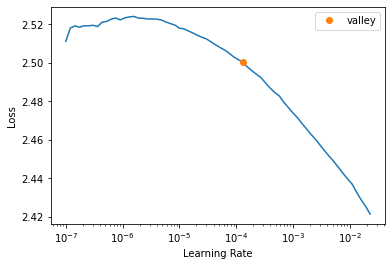

In [17]:
learn.lr_find()

In [17]:
wandb.init(project="uw-madison models", group='exp-27', name=f'TransUnet - ViT - f0')

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


In [ ]:
learn.fit_one_cycle(60,1e-3, 
                    cbs=[SaveModelCallback(monitor='custom_metric_adj', fname='exp-27-f0-v1.0', with_opt=True),
                                    WandbCallback(log_preds=False, model_name=f'TransUnet - ViT - f0')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_adj,custom_metric_adj,time
0,2.205451,2.200862,0.033193,0.436198,12:45
1,2.116218,2.119649,0.189487,0.369384,12:47
2,2.017519,2.014914,0.287101,0.435264,12:47
3,1.911540,1.911575,0.440329,0.545337,12:46
4,1.618042,1.648343,0.394110,0.494475,12:45


Better model found at epoch 0 with custom_metric_adj value: 0.4361976165053255.
Better model found at epoch 3 with custom_metric_adj value: 0.545337141869466.


In [ ]:
train_model('TransUnet', 'ViT', **dict(group='exp-27', version='f0', bs=32, epochs=60, crop=0.9, resize=1.0, fold=0))

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_adj,custom_metric_adj,time
0,1.973444,1.969281,0.179038,0.422168,12:37
1,nan,nan,0.000000,0.600000,12:25
2,nan,nan,0.000000,0.600000,12:15
3,nan,nan,0.000000,0.600000,12:17
4,nan,nan,0.000000,0.600000,12:16
5,nan,nan,0.000000,0.600000,12:14
6,nan,nan,0.000000,0.600000,12:16
7,nan,nan,0.000000,0.600000,12:18
8,nan,nan,0.000000,0.600000,12:20
9,nan,nan,0.000000,0.600000,12:19


Better model found at epoch 0 with custom_metric_adj value: 0.4221681559031685.
Better model found at epoch 1 with custom_metric_adj value: 0.5999999999999973.


wandb: Network error (ConnectionError), entering retry loop.


In [14]:
configs = [
    ('Unet++', 'tf_efficientnet_b5'),
    ('TransUnet', 'ViT'),
    # ('DeepLabV3+', 'timm-efficientnet-b0'),
    # ('DeepLabV3', 'timm-efficientnet-b0'),
    # ('Unet', 'efficientnet_b0'),
    ('DynamicUnet', 'efficientnet_b5'),
]

In [15]:
configs = [
    # ('TransUnet', 'ViT', dict(version=0, aug='albumentations', crop=0.8, resize=0.5)),
    # ('TransUnet', 'ViT', dict(version=1, channels=3, stride=1, crop=0.8, resize=0.5)),
    # ('TransUnet', 'ViT', dict(version=2, channels=5, stride=1, crop=0.8, resize=0.5)),
    # ('TransUnet', 'ViT', dict(version=3, channels=5, stride=2, crop=0.8, resize=0.5)),
    # ('TransUnet', 'ViT', dict(version=4, channels=7, stride=1, crop=0.8, resize=0.5)),
    ('TransUnet', 'ViT', dict(version=5, loss_func=DiceLossSMP(), crop=0.8, resize=0.5)),
    ('TransUnet', 'ViT', dict(version=10, loss_func=ComboLoss(ws=[2, 3, 1]), crop=0.8, resize=0.5)),
    ('TransUnet', 'ViT', dict(version=6, loss_func=ComboLoss(ws=[1, 1, 0]), crop=0.8, resize=0.5)),
    ('TransUnet', 'ViT', dict(version=7, loss_func=ComboLoss(ws=[1, 1, 1]), crop=0.8, resize=0.5)),
    ('TransUnet', 'ViT', dict(version=9, loss_func=ComboLoss(ws=[2, 0, 1]), crop=0.8, resize=0.5)),
]

In [ ]:
for arch, encoder, kwargs in configs:
    print(arch, encoder, kwargs)
    train_model(arch, encoder, **kwargs)

TransUnet ViT {'version': 5, 'loss_func': FlattenedLoss of DiceLoss(), 'crop': 0.8, 'resize': 0.5}


wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_adj,time
0,0.711610,0.858408,0.082338,02:43
1,0.533101,0.779343,0.120150,02:44
2,0.421249,0.567594,0.263179,02:48
3,0.366819,0.629942,0.233023,02:43
4,0.323987,0.475627,0.321244,02:47
5,0.302406,0.517423,0.344758,02:40
6,0.271346,0.401943,0.444084,02:38
7,0.244227,0.381774,0.466822,02:42
8,0.232146,0.376525,0.460996,02:49
9,0.228385,0.368869,0.474633,02:50


TransUnet ViT {'version': 10, 'loss_func': FlattenedLoss of ComboModule(), 'crop': 0.8, 'resize': 0.5}


dice_coeff_adj,▁▂▄▄▅▆▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,██▇▆▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▂▁▂▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_adj,time
0,1.900479,1.793423,0.160950,02:50
1,1.307529,1.358335,0.222048,02:50
2,1.017329,1.494632,0.216341,02:52
3,0.903068,1.990781,0.094453,02:49
4,0.790718,1.167679,0.314639,02:49
5,0.739298,0.996910,0.378594,03:00
6,0.657391,0.920331,0.443708,02:50
7,0.601174,0.885335,0.476747,02:49
8,0.576250,0.859651,0.492379,02:50
9,0.562550,0.852045,0.498317,02:50


TransUnet ViT {'version': 6, 'loss_func': FlattenedLoss of ComboModule(), 'crop': 0.8, 'resize': 0.5}


dice_coeff_adj,▂▃▃▁▅▆▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▆▅▄▄▃▃▃▂▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_adj,time
0,0.889476,0.832670,0.143870,02:50
1,0.634389,0.798775,0.142924,02:51
2,0.484999,0.606370,0.302372,02:52
3,0.428131,0.991474,0.058862,02:50
4,0.376810,0.525789,0.366800,02:50
5,0.348940,0.433016,0.446573,02:50
6,0.310495,0.440706,0.450534,02:50
7,0.284860,0.403142,0.479896,02:49
8,0.270636,0.399659,0.489140,02:50
9,0.264101,0.397557,0.496150,02:49


TransUnet ViT {'version': 7, 'loss_func': FlattenedLoss of ComboModule(), 'crop': 0.8, 'resize': 0.5}


dice_coeff_adj,▂▂▅▁▆▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice_coeff_adj,time
0,0.942271,0.840598,0.186277,02:51
1,0.636535,0.739670,0.165626,02:51
2,0.503763,0.622982,0.293579,02:52
3,0.443421,0.795951,0.192577,02:51
4,0.389864,0.524680,0.366383,02:52
5,0.360862,0.472028,0.407107,02:53
6,0.325104,0.452573,0.448149,02:51
7,0.295694,0.419973,0.482029,03:02


## Augmentations

### Simple augmentations

In [ ]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.RandomContrast(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightness(),
                    ], p=0.3),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    ], p=0.3),
                albumentations.ShiftScaleRotate(),
            ])

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

### test 5 channels

In [ ]:
channels = 5
stride = 1

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.RandomContrast(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightness(),
                    ], p=0.3),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    ], p=0.3),
                albumentations.ShiftScaleRotate(),
            ])

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

### test crop after augmentations

In [ ]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return albumentations.Compose([
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.RandomContrast(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightness(),
                    ], p=0.3),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    ], p=0.3),
                albumentations.ShiftScaleRotate(),
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            ])

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

### test regular unet

In [ ]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.RandomContrast(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightness(),
                    ], p=0.3),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    ], p=0.3),
                albumentations.ShiftScaleRotate(),
            ])

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b0', channels, 3),
                           ComboLoss(),
                           splitter=unet_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

## Progressive resizing vs cropping

### Resizing

In [ ]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return albumentations.Compose([
            # albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            albumentations.Resize(160, 192),
            albumentations.HorizontalFlip(p=p),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            ])

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return albumentations.Compose([
            albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            # albumentations.Resize(160, 192),
            albumentations.HorizontalFlip(p=p),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            ])

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, channels=channels, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

### Cropping

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, channels=channels, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
channels = 5
stride = 1

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, channels=channels, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

## Test different numbers of channels

### 3 channels with one stride

In [ ]:
channels = 3
stride = 1

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(2, 1e-2)

### 3 channels with 2 strides

In [ ]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(2, 1e-2)

### 5 channels with 1 stride

In [ ]:
channels = 5
stride = 1

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(2, 1e-2)

### 7 channels with 1 stride

In [ ]:
channels = 7
stride = 1

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, channels=channels, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', channels, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(2, 1e-2)

## Transfer learning between crops

### Plain 0.9

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', 5, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(3, 1e-2)

### 0.5 followed by 0.9

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', 5, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fine_tune(1, 1e-2)

## Compare 0.5, 0.6 and 0.9 crops

### 0.9

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', 5, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

### 0.6

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.6, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', 5, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

### 0.5

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, val_crop=1.0, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('efficientnet_b0', 5, 3),
                           deep_supervision_loss,
                           metrics=[dice_coeff_deep, custom_metric_deep],
                           splitter=unetplusplus_splitter,
                           cbs=GradientAccumulation(64))

In [ ]:
learn.fine_tune(1, 1e-2)

## Classification Guided Module

In [ ]:
class SegmentationAlbumentationsTransform5C(ItemTransform, RandTransform):
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx): self.idx = split_idx
    
    def encodes(self, x):
        if len(x) > 1 and len(x[1].shape) == 2:
            img, mask = x
            if self.idx == 0:
                aug = self.train_aug(image=np.array(img), mask=np.array(mask))
            else:
                aug = self.valid_aug(image=np.array(img), mask=np.array(mask))
            return aug["image"], PILMask.create(aug["mask"])
        
        elif len(x) > 1 and len(x[1].shape) == 1:
            img, cats = x
            if self.idx == 0:
                aug = self.train_aug(image=np.array(img))
            else:
                aug = self.valid_aug(image=np.array(img))
            return aug["image"], cats.float()
        else:
            img = x[0]
            aug = self.valid_aug(image=np.array(img))
            return aug["image"]
        
def get_targs(row):
    return TensorCategory(row[['lb_seg_flag', 'sb_seg_flag', 'st_seg_flag']].astype(int))


def get_5C_25D_dls(df, up_size=(320, 384), task="mask", crop=0.9, val_crop=0.9, bs=16, sample=False, sample_empty=False, frac=0.2, empty_frac=0.1, aug_p=0.5, val_pct=0.2, show=True, val='group', seed=42):
    
    df = df.copy()
    
    np.random.seed(seed)
    set_seed(seed, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct, seed)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct, seed)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=empty_frac, replace=False, random_state=seed),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=seed)
    else:
        dev = df.sample(frac=1.0, random_state=seed)
    
    if task == "mask":
        tfms = [[partial(get_25D_image, up_size=up_size)],
                [partial(get_mask, up_size=up_size), PILMask.create]]
    elif task == "class":
        tfms = [[partial(get_25D_image, up_size=up_size)], [get_targs]]
    
    after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(up_size, crop=crop, p=aug_p), 
                                                        get_test_aug(up_size, crop=val_crop)),
                  ToTensor()]
    
    # tfms = [[get_25D_image, partial(cv2.resize, dsize=img_size)], [get_mask, partial(cv2.resize, dsize=img_size), PILMask.create]]
    # after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(img_size), get_test_aug(img_size)), ToTensor()]

    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=after_item,
                           after_batch=[IntToFloatTensor, Normalize.from_stats([0.485, 0.485, 0.456, 0.406, 0.406],
                                                                               [0.229, 0.229, 0.224, 0.225, 0.225])])
    dls.rng.seed(seed)
    
    if show:
        nrows = bs//4
        ncols = 4
        dls.show_batch(nrows=nrows, ncols=ncols, max_n=bs, figsize=(ncols*3, nrows*3))
        
    return dls, dev

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, task="class", crop=1.0, val_crop=1.0, sample=False, show=False)

In [ ]:
model = create_timm_model('efficientnet_b3', n_in=5, n_out=3)

In [ ]:
def splitter(model): return L(model[0], model[1]).map(params)

In [ ]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=accuracy_multi, splitter=splitter, cbs=GradientAccumulation(64))

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 1e-3)

In [ ]:
learn.export('uwmadisonutils/cgm.pkl')

### Test it with exp-23 and exp-25

You have to run cells in the previous experiment for this to work.

In [ ]:
def splitter(model): return L(model[0], model[1]).map(params)

In [ ]:
cgm = load_learner('uwmadisonutils/cgm.pkl', cpu=False)
learns = [load_learner('uwmadisonutils/exp-23-v2.1.pkl')]

In [ ]:
for learn in learns:
    learn.model = learn.model.cuda()
    learn.model.eval()
    
cgm.model = cgm.model.cuda()

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=8, val_crop=1.0, show=False)

In [ ]:
x, y = dls.one_batch()

In [ ]:
b_preds = learns[0].model(x)

In [ ]:
cgm_out = cgm.model(x)

In [ ]:
cgm_preds = b_preds[-1] * cgm_out.unsqueeze(-1).unsqueeze(-1)

In [ ]:
cgm_preds = cgm_preds.cpu().detach().numpy()
b_preds = b_preds[-1].cpu().detach().numpy()

In [ ]:
np.where(b_preds.sum((2, 3)) < thresh)

In [ ]:
thresh = [11, 29, 12]
b_preds[np.where(b_preds.sum((2, 3)) < thresh)] = cgm_preds[np.where(b_preds.sum((2, 3)) < thresh)]

In [ ]:
def dice_coeff_adj_pp(inp, targ, pp=False):
    if torch.is_tensor(inp): inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    if pp: inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return None

In [ ]:
def post_process_cgm(b_preds, cgm_preds, threshs=[11, 29, 12]):
    if b_preds.shape[-1] != 3: 
        sum_dims = (2, 3)
    else:
        sum_dims = (1, 2)
    
    threshs = tensor(threshs).cuda()
    b_preds[torch.where(b_preds.sum(sum_dims) < threshs)] = cgm_preds[torch.where(b_preds.sum(sum_dims) < threshs)]
    
    return b_preds

In [ ]:
bs = 8
masks = []

threshs_list = [[11, 29, 12], [22, 58, 24], [30, 30, 30], [50, 50, 50], [70, 70, 70]]

dices = {str(threshs): [] for threshs in threshs_list}
dices['dumb_thresh'] = []

org_imgs = []

# inp_masks = {learn: [] for learn in learns}

# targ_masks = []

val = dev.query('is_valid').reset_index(drop=True)

i = 0
with torch.no_grad():
    for (b, t) in tqdm(dls.valid):
        b.to('cuda')

        for l, learn in enumerate(learns):

            b_preds = get_preds(learn, b)
            
            cgm_out = (sigmoid(cgm.model(b)) > 0.5).float().unsqueeze(-1).unsqueeze(-1)
            
            cgm_preds = b_preds * cgm_out
            
            dices['dumb_thresh'].append(dice_coeff_adj_pp(b_preds, t, pp=True))

            for threshs in threshs_list:
            
                b_preds = post_process_cgm(b_preds, cgm_preds, threshs)

                dices[str(threshs)].append(dice_coeff_adj_pp(b_preds, t))
                
            

#             for j in range(b_preds.shape[0]):

#                 w, h = val.loc[i+j, 'slice_w'], val.loc[i+j, 'slice_h']

#                 pred_mask = (b_preds[j][None, ...] > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

#                 resized_mask = np.moveaxis(resize_img_to_org_size(pred_mask[0], (h, w)), -1, 0)
                
#                 if l == 0:
#                     targ_mask = image2tensor(PILImage.create(get_mask(val.iloc[i+j])))/255
#                     org_img = TensorImage(image2tensor(get_25D_image(val.iloc[i+j])))

#                     targ_masks.append(targ_mask)
#                     org_imgs.append(org_img)
                    
#                 else:
#                     targ_mask = targ_masks[i+j]

#                 dices[learn].append(dice_coeff_adj_pp(resized_mask[None, ...], targ_mask[None, ...]))
#                 inp_masks[learn].append(resized_mask)                

        del b_preds;
        del b;
        del t;
        gc.collect()

        i+=bs

In [ ]:
for key in dices.keys():
    print(key, np.mean([s for s in dices[key] if s != None]))

In [ ]:
dices[str(thresh)]

## Why does exp-23 and exp-25 achieve similar results on LB but different dices locally?

1. exp-23 achieves 0.86 on LB with 0.714 dice score locally
2. exp-25 achieves 0.85 on LB with 0.731 dice score locally
3. exp-23 is improved by TTA and post processing
4. exp-25 is not improved by TTA alone, and is worsened by post processsing

### Could the different be due to hd score? 

To answer that I'll calculate the validations with and without TTA using custom metric.

In [ ]:
def dice_coeff_deep(inp, targ, pp=True):
    inp = np.where(sigmoid(inp[-1]).cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    if pp: inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
def hd_dist_deep(inp, targ, pp=True):
    inp = np.where(sigmoid(inp[-1].cpu()).detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    if pp: inp = post_process(inp)
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0
    
def custom_metric_deep(inp, targ, pp=True):
    hd_score_per_batch = hd_dist_deep(inp, targ, pp)
    dice_score_per_batch = dice_coeff_deep(inp, targ, pp)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, val_crop=1.0, show=False)

In [ ]:
exp_23 = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [partial(dice_coeff_deep, pp=False), partial(custom_metric_deep, pp=False),
                            dice_coeff_deep, custom_metric_deep])

exp_25 = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [partial(dice_coeff_deep, pp=False), partial(custom_metric_deep, pp=False),
                            dice_coeff_deep, custom_metric_deep])

In [ ]:
exp_23 = exp_23.load('exp-23-v2.1')
exp_25 = exp_25.load('exp-25-v1.0')

In [ ]:
exp_23.validate()

In [ ]:
exp_25.validate()

exp-23 is worse than exp-25 by a large margin, which means that it's overfitting the LB. 

In [ ]:
val = dev.query('is_valid')
val.n_segs.hist();

If the public LB has lower number of negative slices, then that would mean that a model that has higher predicatbility will achieve a higher score on the LB, while a model with a better differentiation for negative samples would achieve a slightly lower score as it won't shine due to the different distribution of postitive and negative samples.

### How does TTA affect them both?

In [ ]:
learns = [exp_23, exp_25]

In [ ]:
def get_preds(learn, b, tta=True, deep_ens=False):
    deep_supervision = True if hasattr(learn.model, 'deep_supervision') else False
    
    if tta: 
        b_preds1 = learn.model(b)
        b_preds2 = learn.model(b.flip_lr())
        b_preds3 = learn.model(b.flipud())
        b_preds4 = learn.model(b.flip_lr().flipud())

        if deep_supervision: 
            if deep_ens:
                b_preds1 = (b_preds1[0] + b_preds1[1] + b_preds1[2] + b_preds1[3]) / 4
                b_preds2 = (b_preds2[0] + b_preds2[1] + b_preds2[2] + b_preds2[3]) / 4
                b_preds3 = (b_preds3[0] + b_preds3[1] + b_preds3[2] + b_preds3[3]) / 4
                b_preds4 = (b_preds4[0] + b_preds4[1] + b_preds4[2] + b_preds4[3]) / 4
            else:
                b_preds1 = b_preds1[-1]
                b_preds2 = b_preds2[-1]
                b_preds3 = b_preds3[-1]
                b_preds4 = b_preds4[-1]


        b_preds = (sigmoid(b_preds1) +
                   sigmoid(b_preds2.flip_lr()) +
                   sigmoid(b_preds3.flipud()) + 
                   sigmoid(b_preds4.flip_lr().flipud())) / 4
    else:

        b_preds = learn.model(b)

        if deep_supervision: 
            b_preds = b_preds[-1]

        b_preds = sigmoid(b_preds)
        
    return b_preds

def unpad_img(img, org_size):
    shape0 = np.array(org_size)
    resize = np.array(img.shape[:2])
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        
        if pady[0] != 0:
            img = img[pady[0]:-pady[1], :, :]
            
        if padx[0] != 0:
            img = img[:, padx[0]:-padx[1], :]
            
        img = img.reshape((*shape0, img.shape[-1]))
    return img

def pad_img(img, up_size=None):
    if up_size is None:
        return img
    shape0 = np.array(img.shape[:2])
    resize = np.array(up_size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        padz = [0, 0]
        img = np.pad(img, [pady, padx, padz])
        img = img.reshape((*resize, img.shape[-1]))
    return img

def resize_img_to_org_size(img, org_size):
    shape0 = np.array(img.shape[:2])
    diff = org_size - shape0
    if np.any(diff < 0):
        img = pad_img(img, (320, 384))
        resized = unpad_img(img, org_size)
    else:
        resized = pad_img(img, org_size)
    return resized

In [ ]:
def dice_coeff_adj_pp(inp, targ):
    if torch.is_tensor(inp): inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return None

In [ ]:
for learn in learns:
    learn.model = learn.model.cuda()
    learn.model.eval()
    
bs = 32
masks = []
dices = {learn: [] for learn in learns}

org_imgs = []

inp_masks = {learn: [] for learn in learns}

targ_masks = []

val = dev.query('is_valid').reset_index(drop=True)

i = 0
with torch.no_grad():
    for (b, t) in tqdm(dls.valid):
        b.to('cuda')

        for l, learn in enumerate(learns):

            b_preds = get_preds(learn, b)

            for j in range(b_preds.shape[0]):

                w, h = val.loc[i+j, 'slice_w'], val.loc[i+j, 'slice_h']

                pred_mask = (b_preds[j][None, ...] > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

                resized_mask = np.moveaxis(resize_img_to_org_size(pred_mask[0], (h, w)), -1, 0)
                
                if l == 0:
                    targ_mask = image2tensor(PILImage.create(get_mask(val.iloc[i+j])))/255
                    org_img = TensorImage(image2tensor(get_25D_image(val.iloc[i+j])))

                    targ_masks.append(targ_mask)
                    org_imgs.append(org_img)
                    
                else:
                    targ_mask = targ_masks[i+j]

                dices[learn].append(dice_coeff_adj_pp(resized_mask[None, ...], targ_mask[None, ...]))
                inp_masks[learn].append(resized_mask)                

        del b_preds;
        del b;
        gc.collect()

        i+=bs

In [ ]:
print('exp-23', np.mean([s for s in dices[exp_23] if s != 0]))
print('exp-25', np.mean([s for s in dices[exp_25] if s != 0]))

In [ ]:
val.columns

In [ ]:
val.groupby(['case_id', 'day_num']).n_segs.mean()

## Compare new pretrained unet++ with unet

It turned it to be better by 0.005 in this test, which good enough if it reflected in the LB.

### Implementation

In [ ]:
from segmentation_models_pytorch.base import modules as md
from segmentation_models_pytorch.base import SegmentationHead

class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x
    
class UNetPlusPlus(nn.Module):
    def __init__(self, model, in_channels, classes, decoder_channels=(256, 128, 64, 32, 16), pretrained=True, deep_supervision=True, **kwargs):
        super().__init__()
        
        self.encoder = timm.create_model(model, in_chans=in_channels, pretrained=pretrained, features_only=True)
        
        self.deep_supervision = deep_supervision
        
        encoder_channels = [size[1] for size in timm_model_sizes(self.encoder, (320, 384))]
        
        # computing blocks input and output channels
        head_channels = encoder_channels[-1]
        self.in_channels = [head_channels] + list(decoder_channels[:-1])
        
        self.skip_channels = list(encoder_channels[::-1][1:]) + [0]
        self.out_channels = decoder_channels
        
        
        self.blocks = {}
        
        self.blocks['x_0_1'] = DecoderBlock(encoder_channels[1], encoder_channels[0], decoder_channels[-1])
        self.blocks['x_1_1'] = DecoderBlock(encoder_channels[2], encoder_channels[1], decoder_channels[-2])
        self.blocks['x_2_1'] = DecoderBlock(encoder_channels[3], encoder_channels[2], decoder_channels[-3])
        self.blocks['x_3_1'] = DecoderBlock(encoder_channels[4], encoder_channels[3], decoder_channels[-4])
        
        self.blocks['x_0_2'] = DecoderBlock(decoder_channels[-2], encoder_channels[0]+decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_1_2'] = DecoderBlock(decoder_channels[-3], encoder_channels[1]+decoder_channels[-2], decoder_channels[-2])
        self.blocks['x_2_2'] = DecoderBlock(decoder_channels[-4], encoder_channels[2]+decoder_channels[-3], decoder_channels[-3])
        
        self.blocks['x_0_3'] = DecoderBlock(decoder_channels[-2], encoder_channels[0]+2*decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_1_3'] = DecoderBlock(decoder_channels[-3], encoder_channels[1]+2*decoder_channels[-2], decoder_channels[-2])
        
        self.blocks['x_0_4'] = DecoderBlock(decoder_channels[-2], encoder_channels[0]+3*decoder_channels[-1], decoder_channels[-1])
        
        self.blocks['x_0_1_ex'] = DecoderBlock(decoder_channels[-1], 0, decoder_channels[-1])
        self.blocks['x_0_2_ex'] = DecoderBlock(decoder_channels[-1], decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_0_3_ex'] = DecoderBlock(decoder_channels[-1], 2*decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_0_4_ex'] = DecoderBlock(decoder_channels[-1], 3*decoder_channels[-1], decoder_channels[-1])
        
        for i in range(1, 5):
            self.blocks[f'final_0_{i}'] = SegmentationHead(decoder_channels[-1], classes, kernel_size=3)
        
        
        self.blocks = nn.ModuleDict(self.blocks)
        self.depth = len(self.in_channels)
        
        self.center = nn.Identity()
                
    def forward(self, x):        
        
        dense_x = {f"x_{i}_0": x for i, x in enumerate(self.encoder(x))}
        
        # start building dense connections
        for layer_idx in range(1, len(self.in_channels)):
            # Normal unet++ layers
            for depth_idx in range(self.depth - layer_idx):
                upsample_x = dense_x[f"x_{depth_idx+1}_{layer_idx-1}"]
                cat_x = torch.cat([dense_x[f"x_{depth_idx}_{layer}"] for layer in range(0, layer_idx)], dim=1)
                output = self.blocks[f"x_{depth_idx}_{layer_idx}"](upsample_x, cat_x)
                dense_x[f"x_{depth_idx}_{layer_idx}"] = output
            
            # Extra layers to account for using pretrained encoder 
            upsample_x = dense_x[f"x_0_{layer_idx}"]
            if layer_idx == 1:
                cat_x = None 
            else:
                cat_x = torch.cat([dense_x[f"x_0_{layer}_ex"] for layer in range(1, layer_idx)], dim=1)
            dense_x[f"x_0_{layer_idx}_ex"] = self.blocks[f"x_0_{layer_idx}_ex"](upsample_x, cat_x)
        
        out = [self.blocks[f"final_0_{i}"](dense_x[f"x_0_{i}_ex"]) for i in range(1, 5)]
                    
        return out
    
    
def unetplusplus_splitter(model):
    return L(model.encoder, model.blocks).map(params)

### New unet++

In [ ]:
dls, dev = get_5C_25D_dls(train, crop=0.9, sample=True, sample_empty=True, frac=0.2, show=False)

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus('efficientnet_b0', 5, 3), deep_supervision_loss,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter)

In [ ]:
learn.fit_one_cycle(5, 1e-3)

### Unet++ with dice loss

In [ ]:
def deep_supervision_loss(inp, targ, loss_func=ComboLoss()):
    loss = 0
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

class DiceLossSMP(BaseLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(smp.losses.DiceLoss, *args, mode='multilabel', flatten=False, is_2d=True, floatify=True, **kwargs)

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus('efficientnet_b0', 5, 3),
                           partial(deep_supervision_loss, loss_func=DiceLossSMP()),
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter)

In [ ]:
learn.fit_one_cycle(5, 1e-3)

### Unet++ with DiceFocalLoss

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus('efficientnet_b0', 5, 3),
                           partial(deep_supervision_loss, loss_func=DiceFocalLoss()),
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter)

In [ ]:
learn.fit_one_cycle(5, 1e-3)

### Unet++ with fit_flat_cos and ranger

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus('efficientnet_b0', 5, 3),
                           partial(deep_supervision_loss, loss_func=ComboLoss()),
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter, opt_func=ranger)

In [ ]:
learn.fit_flat_cos(5, 1e-3)

### Unet++ with fit_one_cycle and higher learning rate

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus('efficientnet_b0', 5, 3), deep_supervision_loss,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter)

In [ ]:
learn.fit_one_cycle(5, 1e-2)

### Unet++ with fit_one_cycle and ranger and higher learning rate

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus('efficientnet_b0', 5, 3), deep_supervision_loss,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(5, 1e-2)

### Unet++ with fit_flat_cos and ranger and higher learning rate

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus('efficientnet_b0', 5, 3), deep_supervision_loss,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter, opt_func=ranger)

In [ ]:
learn.fit_flat_cos(5, 1e-2)

### Regular unet

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0', 5, 3), ComboLoss(),
                           splitter=unet_splitter)

In [ ]:
learn.fit_one_cycle(5, 1e-3)

## Checkpoint test

The result of the test is that it doesn't pick up exactly where it stopped, however, it can still be determinstic in that every time you run from the same checkpoint, you'll get the same results.

In [ ]:
dls, dev = get_5C_25D_dls(train, crop=0.5, sample=True, sample_empty=True, frac=0.1, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('resnet18', in_c=5), ComboLoss(), splitter=unet_splitter)

In [ ]:
learn.fit_one_cycle(5, cbs=SaveModelCallback(fname='test_model', every_epoch=True))

In [ ]:
learn.fit_one_cycle(5, start_epoch=3, cbs=SaveModelCallback(fname='test_model', every_epoch=True))

In [ ]:
learn.load('test_model_2')

In [ ]:
learn.fit_one_cycle(5, start_epoch=3, cbs=SaveModelCallback(fname='test_model_2', every_epoch=True, reset_on_fit=False))

In [ ]:
learn.fit_one_cycle(5, start_epoch=3)

In [ ]:
learn.fit_one_cycle(5, cbs=SkipToEpoch(3))

In [ ]:
learn.fit_one_cycle(5, cbs=SkipToEpoch(3))

In [ ]:
learn.fit_one_cycle(5, start_epoch=2)

In [ ]:
learn.fit_one_cycle(5, start_epoch=3)

In [ ]:
learn.fit_one_cycle(5, start_epoch=3)

In [ ]:
learn.recorder.plot_sched()

## Unet++ with pretrained backbone and deep supervision

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output


class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final4(x0_4)
            return output

In [ ]:
encoder = timm.create_model('efficientnet_b0', in_chans=5, pretrained=True, features_only=True)

In [ ]:
timm_model_sizes(encoder, (320, 384))

#### Let's test adding this encoder into simple unet

In [ ]:
from segmentation_models_pytorch.base import modules as md
from segmentation_models_pytorch.base import SegmentationHead

class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class UNet(nn.Module):
    def __init__(self, model, in_channels, classes, decoder_channels=(256, 128, 64, 32, 16), pretrained=True, **kwargs):
        super().__init__()
        
        self.encoder = timm.create_model(model, in_chans=in_channels, pretrained=pretrained, features_only=True)
        
        encoder_channels = [size[1] for size in timm_model_sizes(encoder, (320, 384))]
        
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
        
            
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        
        self.center = nn.Identity()
        
        self.blocks = nn.ModuleList(blocks)
        self.final = SegmentationHead(decoder_channels[-1], classes, kernel_size=3)
        
    def forward(self, x):
        features = self.encoder(x)
        
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]
    
        
        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)
        
        return self.final(x)
        

In [ ]:
dls, dev = get_5C_25D_dls(train, crop=0.5, sample=True, sample_empty=True, frac=0.01, show=False)

In [ ]:
def custom_splitter(model):
    return L(model).map(params)

In [ ]:
learn = get_custom_learner(dls, UNet(encoder, 5, 3), ComboLoss(), splitter=nested_splitter)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0', in_c=5), ComboLoss(), splitter=nested_splitter)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2)

The results are similar enough, so we can move on to make the unet++.

In [ ]:
for layer in range(5):
    # loop over depth
    for depth in range(5-layer):
        print(depth, layer)

In [ ]:
class UNetPlusPlus(nn.Module):
    def __init__(self, encoder, in_channels, classes, decoder_channels=(256, 128, 64, 32, 16), deep_supervision=True, **kwargs):
        super().__init__()
        
        self.encoder = encoder
        
        encoder_channels = [size[1] for size in timm_model_sizes(encoder, (320, 384))]
        
        # computing blocks input and output channels
        head_channels = encoder_channels[-1]
        self.in_channels = [head_channels] + list(decoder_channels[:-1])
        
        self.skip_channels = list(encoder_channels[::-1][1:]) + [0]
        self.out_channels = decoder_channels
        
        
        self.blocks = {}
        
        self.blocks['x_0_1'] = DecoderBlock(encoder_channels[1], encoder_channels[0], decoder_channels[-1])
        self.blocks['x_1_1'] = DecoderBlock(encoder_channels[2], encoder_channels[1], decoder_channels[-2])
        self.blocks['x_2_1'] = DecoderBlock(encoder_channels[3], encoder_channels[2], decoder_channels[-3])
        self.blocks['x_3_1'] = DecoderBlock(encoder_channels[4], encoder_channels[3], decoder_channels[-4])
        
        self.blocks['x_0_2'] = DecoderBlock(decoder_channels[-2], encoder_channels[0]+decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_1_2'] = DecoderBlock(decoder_channels[-3], encoder_channels[1]+decoder_channels[-2], decoder_channels[-2])
        self.blocks['x_2_2'] = DecoderBlock(decoder_channels[-4], encoder_channels[2]+decoder_channels[-3], decoder_channels[-3])
        
        self.blocks['x_0_3'] = DecoderBlock(decoder_channels[-2], encoder_channels[0]+2*decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_1_3'] = DecoderBlock(decoder_channels[-3], encoder_channels[1]+2*decoder_channels[-2], decoder_channels[-2])
        
        self.blocks['x_0_4'] = DecoderBlock(decoder_channels[-2], encoder_channels[0]+3*decoder_channels[-1], decoder_channels[-1])
        
        self.blocks['x_0_1_ex'] = DecoderBlock(decoder_channels[-1], 0, decoder_channels[-1])
        self.blocks['x_0_2_ex'] = DecoderBlock(decoder_channels[-1], decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_0_3_ex'] = DecoderBlock(decoder_channels[-1], 2*decoder_channels[-1], decoder_channels[-1])
        self.blocks['x_0_4_ex'] = DecoderBlock(decoder_channels[-1], 3*decoder_channels[-1], decoder_channels[-1])
        
        for i in range(1, 5):
            self.blocks[f'final_0_{i}'] = SegmentationHead(decoder_channels[-1], classes, kernel_size=3)
        
        
        self.blocks = nn.ModuleDict(self.blocks)
        self.depth = len(self.in_channels)
        
        self.center = nn.Identity()
                
    def forward(self, x):        
        
        dense_x = {f"x_{i}_0": x for i, x in enumerate(self.encoder(x))}
        
        # start building dense connections
        for layer_idx in range(1, len(self.in_channels)):
            # Normal unet++ layers
            for depth_idx in range(self.depth - layer_idx):
                upsample_x = dense_x[f"x_{depth_idx+1}_{layer_idx-1}"]
                cat_x = torch.cat([dense_x[f"x_{depth_idx}_{layer}"] for layer in range(0, layer_idx)], dim=1)
                output = self.blocks[f"x_{depth_idx}_{layer_idx}"](upsample_x, cat_x)
                dense_x[f"x_{depth_idx}_{layer_idx}"] = output
            
            # Extra layers to account for using pretrained encoder 
            upsample_x = dense_x[f"x_0_{layer_idx}"]
            if layer_idx == 1:
                cat_x = None 
            else:
                cat_x = torch.cat([dense_x[f"x_0_{layer}_ex"] for layer in range(1, layer_idx)], dim=1)
            dense_x[f"x_0_{layer_idx}_ex"] = self.blocks[f"x_0_{layer_idx}_ex"](upsample_x, cat_x)
        
        out = [self.blocks[f"final_0_{i}"](dense_x[f"x_0_{i}_ex"]) for i in range(1, 5)]
                    
        return out

In [ ]:
dls, dev = get_5C_25D_dls(train, crop=0.9, sample_empty=False, show=False)

In [ ]:
encoder = timm.create_model('efficientnet_b0', in_chans=5, pretrained=False, features_only=True)

In [ ]:
learn = get_custom_learner(dls, UNetPlusPlus(encoder, 5, 3), deep_supervision_loss,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           splitter=custom_splitter)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

## Test Time Augmentation

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

In [ ]:
learn = load_learner('uwmadisonutils/exp-15-v3.pkl')

In [ ]:
learn.dls = dls

In [ ]:
x, y = dls.valid.one_batch()

In [ ]:
img = x[0, [1, 2, 3]]
img_lr = x.flip_lr()[0, [1, 2, 3]]
img_lr_ud = x.flip_lr().flipud()[0, [1, 2, 3]]
img_ud = x.flipud()[0, [1, 2, 3]]
img_rot90 = x.rot90()[0, [1, 2, 3]]

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
img.show(ctx=axes[0])
img_lr.show(ctx=axes[1])
img_ud.show(ctx=axes[2])
img_lr_ud.show(ctx=axes[3])
img_rot90.show(ctx=axes[4])

In [ ]:
learn.model = learn.model.cuda()
learn.model.eval()
masks = []

with torch.no_grad():
    for i, b in enumerate(tqdm(test_dl)):
        b.to('cuda')
        b_1 = b.flip_lr()
        b_2 = b.flipud()
        b_3 = b.flip_lr().flipud()
        
        b_preds = (sigmoid(learn.model(b)) +
                   sigmoid(learn.model(b_1).flip_lr()) +
                   sigmoid(learn.model(b_2).flipud()) + 
                   sigmoid(learn.model(b_3).flip_lr().flipud())) / 4
        
        b_preds = (b_preds > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

        b_preds = post_process(b_preds, test.iloc[i*bs:i*bs+bs]['slice_no'].values)
        masks.extend(get_rle_masks(b_preds, test.iloc[i*bs:i*bs+bs]))

        # test_preds[i*bs:i*bs+bs] = b_preds
        del b_preds
        torch.cuda.empty_cache()
        gc.collect()

## Upsize with Pad vs Squish

In [ ]:
img = PILImage.create(get_25D_image(train.iloc[20]))
img

In [ ]:
up_img = Resize((384, 320), method='squish')(img)
up_img

In [ ]:
img.size - up_img.size

In [ ]:
PILImage.create(np.array(up_img)[

## Test 5 channel 2.5D data

In [ ]:
# https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda
def get_custom_df(df, fnames, root):    
    # 1. Get Case-ID as a column (str and int)
    df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
    df["case_id"] = df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

    # 2. Get Day as a column
    df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
    df["day_num"] = df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))
    
    # Add case_day str column
    df["case_id_day_num_str"] = df["case_id_str"] + "_" + df["day_num_str"]

    # 3. Get Slice Identifier as a column
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])

    # 4. Get full file paths for the representative scans
    df["_partial_fname"] = (root+'/'+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                          df["case_id_str"]+"/"+ # .../case###/
                          df["case_id_str"]+"_"+df["day_num_str"]+ # .../case###_day##/
                          "/scans/"+df["slice_id"]) # .../slice_####
    
    _tmp_merge_df = pd.DataFrame({"_partial_fname":[str(x).rsplit("_",4)[0] for x in fnames], "fname": fnames})
    df = df.merge(_tmp_merge_df, on="_partial_fname").drop(columns=["_partial_fname"])
    
    # Minor cleanup of our temporary workaround
    del _tmp_merge_df; gc.collect(); gc.collect()
    
    # 5. Get slice dimensions from filepath (int in pixels)
    df["slice_h"] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
    df["slice_w"] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))

    # 6. Pixel spacing from filepath (float in mm)
    df["px_spacing_h"] = df["fname"].apply(lambda x: float(str(x)[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["fname"].apply(lambda x: float(str(x)[:-4].rsplit("_",4)[4]))

    # 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
    l_bowel_train_df = df[df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
    s_bowel_train_df = df[df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
    stomach_train_df = df[df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
    df = df.merge(l_bowel_train_df, on="id", how="left")
    df = df.merge(s_bowel_train_df, on="id", how="left")
    df = df.merge(stomach_train_df, on="id", how="left")
    df = df.drop_duplicates(subset=["id",]).reset_index(drop=True)
    df["lb_seg_flag"] = df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
    df["sb_seg_flag"] = df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
    df["st_seg_flag"] = df["st_seg_rle"].apply(lambda x: not pd.isna(x))
    df["n_segs"] = df["lb_seg_flag"].astype(int)+df["sb_seg_flag"].astype(int)+df["st_seg_flag"].astype(int)
    
    df = df.sort_values(by=['id']).copy()
    
    # Add 2.5D fnames
    channels=5
    stride=1
    
    for j, i in enumerate(range(-1*(channels-channels//2-1), channels//2+1)):
        method = 'ffill'
        if i <= 0: method = 'bfill'
        df[f'fname_{j:02}'] = df.groupby(['case_id', 'day_num'])['fname'].shift(stride*-i).fillna(method=method)
        # df['fname_01'] = df.groupby(['case_id', 'day_num'])['fname'].shift(1*stride).fillna(method='bfill')
        # df['fname_02'] = df.groupby(['case_id', 'day_num'])['fname'].shift(0*stride).fillna(method='bfill')
        # df['fname_03'] = df.groupby(['case_id', 'day_num'])['fname'].shift(-1*stride).fillna(method='ffill')
        # df['fname_04'] = df.groupby(['case_id', 'day_num'])['fname'].shift(-2*stride).fillna(method='ffill')
    
    # for i in range(channels):
    #     df[f'fname_{i:02}'] = df.groupby(['case_id','day_num'])['fname'].shift(-i*stride).fillna(method="ffill")
    df['fnames'] = df[[f'fname_{j:02d}' for j in range(channels)]].values.tolist()

    # 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
    df = df[["id", "fname", "fnames", "n_segs",
             "lb_seg_rle", "lb_seg_flag",
             "sb_seg_rle", "sb_seg_flag", 
             "st_seg_rle", "st_seg_flag",
             "slice_h", "slice_w", "px_spacing_h", 
             "px_spacing_w", "case_id_str", "case_id", 
             "day_num_str", "day_num", "case_id_day_num_str", "slice_id",]].reset_index(drop=True)
    

    return df

In [ ]:
path = Path(data_path+'train')
test_path = Path(data_path+'test')
train = pd.read_csv(data_path+'train.csv', low_memory=False)
fnames = get_image_files(path)
train = get_custom_df(train, fnames, data_path+'train')

In [ ]:
import PIL

@ToTensor
def encode(x: PIL.Image.Image): return image2tensor(x)

In [ ]:
def get_25D_image(row):
    imgs = np.zeros((row['slice_w'], row['slice_h'], len(row['fnames'])))
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname)
        imgs[..., i]+=img
    return imgs.astype(np.uint8)


def get_25D_dls(df, img_size=224, method='squish', aug='albumentations', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df
    
    tfms = [[get_25D_image, partial(Image.fromarray, mode='RGB')], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    
    if aug == 'albumentations':
        after_item = [Resize(img_size, method=method),
                             SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                             ToTensor()]
        after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
        
    elif aug == 'fastai':
        after_item = [Resize(img_size, method=method),ToTensor()]
        after_batch = [IntToFloatTensor, *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
    
    dls = dsets.dataloaders(bs=bs, after_item=after_item, after_batch=after_batch)
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

In [ ]:
pipeline = Pipeline([Resize(320, method='squish'),
                             SegmentationAlbumentationsTransform(get_train_aug(320), 0),
                             ToTensor()])

In [ ]:
img = Image.fromarray(get_25D_image(train.iloc[0]), mode='RGB')

In [ ]:
type(ToTensor()(pipeline(img)))

In [ ]:
dls, dev = get_25D_dls(train)

## Test custom unet++

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output


class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, sample=True, sample_empty=True, show=False)

In [ ]:
unet = NestedUNet(3, 3, deep_supervision=False)

In [ ]:
def splitter(model): return L(model).map(params)

In [ ]:
learn = get_custom_learner(dls, unet, ComboLoss(), splitter)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-2)

### With deep supervision

In [ ]:
def deep_supervision_loss(inp, targ):
    loss = 0
    loss_func = ComboLoss()
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

def dice_coeff2(inp, targ):
    inp = np.where(inp[-1].cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
    
def hd_dist_per_slice(inp, targ):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    # if len(targ) == 0:
    #     inp = 1 - inp
    #     targ = 1 - targ
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist2(inp, targ):
    inp = np.where(inp[-1].cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric2(inp, targ):
    hd_score_per_batch = hd_dist2(inp, targ)
    dice_score_per_batch = dice_coeff2(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, NestedUNet(3, 3, deep_supervision=True), deep_supervision_loss, splitter, metrics=[dice_coeff2, hd_dist2, custom_metric2])

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-2)

## Progressive resizing

In [ ]:
img_size = [320, 384]
hf_img_size = [sz//2 for sz in img_size]

In [ ]:
hf_img_size

In [ ]:
dls, dev = get_25D_dls(train, img_size=hf_img_size, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(5, 3e-2)

In [ ]:
dls, dev = get_25D_dls(train, img_size=img_size, sample=True, sample_empty=True, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.fit_one_cycle(5, 3e-2)

### Without

In [ ]:
dls, dev = get_25D_dls(train, img_size=img_size, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

## Unet#

In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, ni, nf, final_div=True, blur=False, act_cls=defaults.activation,
                 self_attention=False, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        super().__init__()
        self.conv1 = ConvLayer(ni, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, act_cls=act_cls, norm_type=norm_type,
                               xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = act_cls()
        apply_init(nn.Sequential(self.conv1, self.conv2), init)
        
    def forward(self, x):
        return self.conv2(self.conv1(x))

class UNetDashDecoder(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.sizes = sizes
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.up8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.up16 = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
        
        self.unet0_1 = UNetBlock(self.sizes[0]+self.sizes[1], self.sizes[0])
        self.unet1_1 = UNetBlock(self.sizes[1]+self.sizes[2], self.sizes[1])
        self.unet2_1 = UNetBlock(self.sizes[2]+self.sizes[3], self.sizes[2])
        self.unet3_1 = UNetBlock(self.sizes[3]+self.sizes[4], self.sizes[3])
        
        self.unet0_2 = UNetBlock(2*self.sizes[0]+self.sizes[1]+self.sizes[2], self.sizes[0])
        self.unet1_2 = UNetBlock(2*self.sizes[1]+self.sizes[2]+self.sizes[3], self.sizes[1])
        self.unet2_2 = UNetBlock(2*self.sizes[2]+self.sizes[3]+self.sizes[4], self.sizes[2])
        
        self.unet0_3 = UNetBlock(3*self.sizes[0]+self.sizes[1]+self.sizes[2]+self.sizes[3], self.sizes[0])
        self.unet1_3 = UNetBlock(3*self.sizes[1]+self.sizes[2]+self.sizes[3]+self.sizes[4], self.sizes[1])
        
        self.unet0_4 = UNetBlock(4*self.sizes[0]+self.sizes[1]+self.sizes[2]+self.sizes[3]+self.sizes[4], self.sizes[0])

        
        
    def forward(self, x0_0, x1_0, x2_0, x3_0, x4_0):
        x0_1 = self.unet0_1(torch.cat([x0_0, self.up2(x1_0)], 1))
        x1_1 = self.unet1_1(torch.cat([x1_0, self.up2(x2_0)], 1))
        x2_1 = self.unet2_1(torch.cat([x2_0, self.up2(x3_0)], 1))
        x3_1 = self.unet3_1(torch.cat([x3_0, self.up2(x4_0)], 1))
        
        x0_2 = self.unet0_2(torch.cat([x0_0, x0_1, self.up2(x1_1), self.up4(x2_0)], 1))
        x1_2 = self.unet1_2(torch.cat([x1_0, x1_1, self.up2(x2_1), self.up4(x3_0)], 1))
        x2_2 = self.unet2_2(torch.cat([x2_0, x2_1, self.up2(x3_1), self.up4(x4_0)], 1))
        
        x0_3 = self.unet0_3(torch.cat([x0_0, x0_1, x0_2, self.up2(x1_2), self.up4(x2_1), self.up8(x3_0)], 1))
        x1_3 = self.unet1_3(torch.cat([x1_0, x1_1, x1_2, self.up2(x2_2), self.up4(x3_1), self.up8(x4_0)], 1))
                                            
        x0_4 = self.unet0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up2(x1_3), self.up4(x2_2), self.up8(x3_1), self.up16(x4_0)], 1))
        
        return x0_1, x0_2, x0_3, x3_1, x2_2, x1_3, x0_4
        
        

class UNetDash(nn.Module):
    def __init__(self, encoder, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        self.encoder = encoder
        self.sizes = [size[1] for size in timm_model_sizes(encoder, (224, 224))]
        self.decoder = UNetDashDecoder(self.sizes)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.up8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.up16 = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
        
        if self.deep_supervision:
            final_in = 4*self.sizes[0]+self.sizes[1]+self.sizes[2]+self.sizes[3]
        else:
            final_in = self.sizes[0]
            
        self.final = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'), 
                                   ConvLayer(final_in, final_in//2, ks=1, act_cls=None, norm_type=None),
                                   ConvLayer(final_in//2, 3, ks=1, act_cls=None, norm_type=None))     
        
    def forward(self, x):
        x0_0, x1_0, x2_0, x3_0, x4_0 = self.encoder(x)
        x0_1, x0_2, x0_3, x3_1, x2_2, x1_3, x0_4 = self.decoder(x0_0, x1_0, x2_0, x3_0, x4_0)
        
        if self.deep_supervision:
            return self.final(torch.cat([x0_1, x0_2, x0_3, self.up8(x3_1), self.up4(x2_2), self.up2(x1_3), x0_4], 1))
        else:
            return self.final(x0_4)

In [ ]:
unet = UNetDash(timm.create_model('efficientnet_b0', features_only=True), deep_supervision=False)

In [ ]:
def splitter(model):
    return L(model.encoder, model.decoder, model.final).map(params)

In [ ]:
dls, dev = get_25D_dls(train, img_size=(320, 384), aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, unet, ComboLoss(), splitter)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, 0.1)

In [ ]:
learn.show_results()

## Large Image Sizes

I'll use the latest test in CLAHE as a reference score and will go on and test.

### Implemenetation

In [ ]:
img = PILImage.create(get_image(train.iloc[0]))
img.show();

In [ ]:
rsz = Resize(size=(320,384), method='squish')
rsz_img = rsz(img)

In [ ]:
rsz_img.shape

### Test

In [ ]:
dls, dev = get_25D_dls(train, img_size=(320, 384), method='squish', sample=True, sample_empty=True)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), FocalTverskyLoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(5, 3e-2)

## Adding CLAHE

### Control

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(5, 3e-2)

### Test

In [ ]:
def get_image(row):
    img = np.array(Image.open(row['fname']))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    img = albumentations.CLAHE()(image=get_image(train.iloc[i]).astype(np.uint8))['image']
    return img

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(5, 3e-2)

## Combo BCE + Focal Loss + Dice

In [ ]:
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class ComboModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss + self.ws[2]*bce_loss
    
class ComboLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(ComboModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), ComboLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-2)

### Try different weights

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), ComboLoss(ws=[2, 3, 1]), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

Combo Loss is a total killer, let's try it with Unet++

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_unet_pp('efficientnet-b1'), ComboLoss(ws=[2, 3, 1]), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

## Unet++

In [ ]:
def build_unet_pp(encoder_name):
    model = smp.UnetPlusPlus(
        encoder_name=encoder_name,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to('cuda')
    return model

### Control

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

### Test

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_unet_pp('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

## Progressive resizing

### Control

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=True)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(10, lr)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/400, lr/4))

### Test

In [ ]:
dls, dev = get_25D_dls(train, img_size=128, aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(5, lr)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/400, lr/4))

In [ ]:
learn.save('stage-1')

In [ ]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.load('stage-1')

In [ ]:
learn.lr_find()

In [ ]:
lr = 4e-3

In [ ]:
learn.fit_one_cycle(5, lr)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/400, lr/4))

## Use random crops 

### Control

In [ ]:
def get_25D_dls(df, img_size=224, method='squish', aug='albumentations', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df
    
    tfms = [[get_25D_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    
    if aug == 'albumentations':
        after_item = [Resize(img_size, method=method),
                             SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                             ToTensor()]
        after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
        
    elif aug == 'fastai':
        after_item = [Resize(266, method='pad'),ToTensor()]
        after_batch = [IntToFloatTensor, *aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
    
    dls = dsets.dataloaders(bs=bs, after_item=after_item, after_batch=after_batch)
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

In [ ]:
dls, dev = get_25D_dls(train, aug='albumentations', sample=True, sample_empty=True, show=True)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(5, 3e-2)

### Test

In [ ]:
dls, dev = get_25D_dls(train, aug='fastai', sample=True, sample_empty=True, show=True)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(5, 3e-2)

## Use Tversky Loss

In [ ]:
class TverskyLossModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            inp = torch.sigmoid(inp)
            
        inp_0, inp_1 = inp, 1 - inp
        targ_0, targ_1 = targ, 1 - targ
            
        num = (inp_0 * targ_0).sum() 
        denom = num + (self.alpha * (inp_0 * targ_1).sum()) + (self.beta * (inp_1 * targ_0).sum()) + self.eps
        loss = 1 - (num / denom)
        return loss**self.gamma 
    
class TverskyLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4, thresh=0.5, **kwargs):
        super().__init__(TverskyLossModule, *args, eps=eps, from_logits=from_logits, alpha=alpha, beta=beta, gamma=gamma, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

### Control

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), DiceFocalLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

### Test

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), TverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

In [ ]:
learn.show_results()

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), TverskyLoss(gamma=1), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

## Use Focal Loss

In [ ]:
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class DiceFocalModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss
    
class DiceFocalLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(DiceFocalModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

### Baseline

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
unet = build_model('efficientnet-b1')

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 2e-2)

### Test

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
unet = build_model('efficientnet-b1')

In [ ]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 2e-2)

Now I know that it's better, but let's test removing the multiplier of focal loss.

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
unet = build_model('efficientnet-b1')

In [ ]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(n=1), unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 2e-2)

I want to try my dynamic model for the last time.

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224), self_attention=True)

In [ ]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(), dynamic_unet_splitter)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 2e-3)

Another time without self attention

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [ ]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(), dynamic_unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 2e-3)

## Use 2.5 Data

### Baseline

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
# encoder = timm.create_model('efficientnet_b0', pretrained=True)
# unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

unet = build_model('efficientnet-b1')

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(3, 2e-2)

### Test

#### Implementation

In [ ]:
channels=3
stride=2
for i in range(channels):
    train[f'fname_{i:02}'] = train.groupby(['case_id','day_num'])['fname'].shift(-i*stride).fillna(method="ffill")
train['fnames'] = train[[f'fname_{i:02d}' for i in range(channels)]].values.tolist()
train.fnames[0]

In [ ]:
def load_image(fname):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img

def get_25D_image(row):
    imgs = np.zeros((row['slice_w'], row['slice_h'], len(row['fnames'])))
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname)
        imgs[..., i]+=img
    return imgs.astype(np.uint8)

def get_25D_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df
    
    tfms = [[get_25D_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=[Resize(img_size, method=method),
                                               SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                                               ToTensor()],
                           after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=True)

In [ ]:
# encoder = timm.create_model('efficientnet_b0', pretrained=True)
# unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

unet = build_model('efficientnet-b1')

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 2e-2)

### Dynamic

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=True)

In [ ]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224), self_attention=True)

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224), self_attention=True)

In [ ]:
learn.fit_one_cycle(10, 2e-2)

## Compare training encoder on category task first

### Baseline

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=False, show=False)

In [ ]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

In [ ]:
learn.fit_one_cycle(3, 1e-3)

### Test

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=False, show=False)

In [ ]:
def get_cat_dls(df, img_size=224, method='squish'):
    db = DataBlock((ImageBlock(cls=PILImageBW), MultiCategoryBlock(encoded=True, vocab={'lb': 0, 'sb': 1, 'st': 2})),
               get_x=get_image,
               get_y=get_targs,
               splitter = ColSplitter(),
               item_tfms=[Resize(img_size, method=method), AlbumentationsTransform(get_train_aug(img_size), 0)],
               batch_tfms=[Normalize.from_stats(*imagenet_stats)])
    
    set_seed(SEED, True)
    return db.dataloaders(df, bs=16, shuffle=True)

In [ ]:
cat_dls = get_cat_dls(dev)

In [ ]:
def get_cat_model(unet):
    body = nn.Sequential(*encoder.children())[:-2]
    head = create_head(1280, 3)
    return CatModel(body, head)

In [ ]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))
cat_model = get_cat_model(unet)

In [ ]:
cat_learn = Learner(cat_dls, cat_model, BCEWithLogitsLossFlat(), splitter=cat_splitter, metrics=accuracy_multi)

In [ ]:
cat_learn.lr_find()

In [ ]:
cat_learn.fine_tune(5, 1e-4)

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 1e-3)

Didn't improve performance, so I'll drop it.

## Compare my dynamic unet with smp's unet

### Dynamic Timm Unet

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [ ]:
def dynamic_unet_splitter(model):
    return L(model[0], model[1:]).map(params)

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

### SMP's unet

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 2e-2)

Mine is better.

## Test training encoder first

### Implementation

#### Create model and isolate encoder (Failed)

In [ ]:
unet = build_model('efficientnet-b0')

In [ ]:
body = create_body(resnet18)

In [ ]:
body = nn.Sequential(*unet.encoder.children())
head = create_head(1280, 3)

class CustomModel(nn.Module):
    def __init__(self, body, head):
        super(CustomModel, self).__init__()
        self.body = body
        self.head = head
    def forwards(self, x):
        return self.head(self.body(x))

In [ ]:
type(unet.encoder)

In [ ]:
unet.encoder

In [ ]:
unet.encoder(torch.zeros((1, 3, 224, 224)).cuda())[0].shape

In [ ]:
body = TimmBody('efficientnet_b0')

In [ ]:
cat_model = CustomModel(body, head)

#### Create dynamic unet using timm and fastai

In [ ]:
import timm

def timm_model_sizes(encoder, img_size):
    sizes = []
    for layer in encoder.feature_info:
        sizes.append(torch.Size([1, layer['num_chs'], img_size[0]//layer['reduction'], img_size[1]//layer['reduction']]))
    return sizes


def get_timm_output_layers(encoder):
    outputs = []
    for layer in encoder.feature_info:
        # Converts 'blocks.0.0' to ['blocks', '0', '0']
        attrs = layer['module'].split('.')
        output_layer = getattr(encoder, attrs[0])[int(attrs[1])][int(attrs[2])]
        outputs.append(output_layer)
    return outputs


class DynamicTimmUnet(SequentialEx):
    "Create a U-Net from a given architecture in timm."
    def __init__(self, encoder, n_out, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = timm_model_sizes(encoder, (224, 224))
        sz_chg_idxs = list(reversed(range(len(sizes))))
        outputs = list(reversed(get_timm_output_layers(encoder)))
        self.sfs = hook_outputs(outputs, detach=False)
        
        # cut encoder
        encoder = nn.Sequential(*list(encoder.children()))[:-5]
        
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        #apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        layers.append(ToTensorBase())
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [ ]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [ ]:
body = nn.Sequential(*encoder.children())[:-2]
head = create_head(1280, 3)

class CatModel(nn.Module):
    def __init__(self, body, head):
        super(CatModel, self).__init__()
        self.body = body
        self.head = head
    def forward(self, x):
        return self.head(self.body(x))

In [ ]:
cat_model = CatModel(body, head)

In [ ]:
dummy_eval(cat_model, (224, 224)).shape

#### Create dataset

In [ ]:
def get_targs(row): return row[['lb_seg_flag', 'sb_seg_flag', 'st_seg_flag']].values.astype(np.uint8)

In [ ]:
mask_dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
class AlbumentationsTransform(DisplayedTransform):
    order = 2
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x: PILImage):
        aug = self.aug(image=np.array(x))
        return PILImage.create(aug["image"])

In [ ]:
db = DataBlock((ImageBlock(cls=PILImageBW), MultiCategoryBlock(encoded=True, vocab={'lb': 0, 'sb': 1, 'st': 2})),
               get_x=get_image,
               get_y=get_targs,
               splitter = ColSplitter(),
               item_tfms=[Resize(224, method='squish'), AlbumentationsTransform(get_train_aug(224), 0)],
               batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [ ]:
set_seed(SEED, True)
cat_dls = db.dataloaders(dev, bs=16, shuffle=True)

#### Create learner

In [ ]:
def splitter(model): return L(model.body, model.head).map(params)

In [ ]:
cat_learn = Learner(cat_dls, cat_model, BCEWithLogitsLossFlat(), splitter=splitter, metrics=accuracy_multi)

In [ ]:
cat_learn.lr_find()

#### Check params of unet before and after

In [ ]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [ ]:
params(encoder)[0][0]

In [ ]:
params(unet)[0][0]

In [ ]:
set_seed(SEED, True)
cat_dls = db.dataloaders(dev, bs=16, shuffle=True)

In [ ]:
body = nn.Sequential(*encoder.children())[:-2]
head = create_head(1280, 3)
cat_model = CatModel(body, head)

In [ ]:
cat_learn = Learner(cat_dls, cat_model, BCEWithLogitsLossFlat(), splitter=splitter, metrics=accuracy_multi)

In [ ]:
cat_learn.fine_tune(1, 1e-3)

In [ ]:
params(unet)[4] == params(cat_learn.model)[4]

## Test removing true empty positives from metrics

### Control

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(3, 2e-2)

In [ ]:
def dice_coeff(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        inp_i, targ_i, dice_i = inp[i], targ[i], []
        for j in range(targ.shape[1]):
            inp_ij, targ_ij = inp_i[j], targ_i[j]
            if inp_ij.sum() == targ_ij.sum() == 0:
                continue
            I = (targ_ij * inp_ij).sum()
            U =  targ_ij.sum() + inp_ij.sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    return np.mean(dice_scores)

In [ ]:
def hd_dist(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    return np.mean(hd_scores)

In [ ]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(3, 2e-2)

## Test conditionals in metrics

### Regular metrics

In [ ]:
dls, dev = get_aug_dls(train, aug_transforms(), sample=True, sample_empty=True, show=False, val='group')

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [ ]:
learn.fit_flat_cos(2, 1e-2)

### New metrics

In [ ]:
def dice_coeff(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    if targ.sum() == 0:
        if inp.sum() == 0:
            return 1
        else:
            return 0
    eps = 1e-5
    I = (targ * inp).sum((2, 3))
    U =  targ.sum((2,3)) + inp.sum((2, 3))
    return ((2.*I+eps)/(U+eps)).mean((1, 0))


def hd_dist_per_slice(inp, targ):
    if targ.sum() == 0:
        if inp.sum() == 0:
            return 1
        else:
            return 0
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

In [ ]:
dls, dev = get_aug_dls(train, aug_transforms(), sample=True, sample_empty=True, show=False, val='group')

In [ ]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [ ]:
learn.fit_flat_cos(2, 1e-2)

## Test dropping empty masks from training data

In [ ]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=True, sample_empty=True, show=False, val='group')

In [ ]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_flat_cos(10, 2e-2)

## Test group case validation score over efficientnet sample baseline

In [ ]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=True, show=False, val='group')

In [ ]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, 2e-2)

The score has decreased, which means that I probably should use it over custom validation as it is more similar to the public LB.

## Use custom albumentations augmentation

In [ ]:
import albumentations

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [ ]:
def get_train_aug(): return albumentations.Compose([
            # albumentations.RandomResizedCrop(224,224),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            # albumentations.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(224,224, p=1.),
    albumentations.Resize(224,224),
    albumentations.CoarseDropout(p=0.5)
], p=1.)

In [ ]:
tfms = [[get_image, PILImageBW.create], [get_mask, PILMask.create]]
splits = ColSplitter()(train)
dsets = Datasets(train, tfms, splits=splits)
dls = dsets.dataloaders(bs=16, after_item=[Resize(224),
                                           SegmentationAlbumentationsTransform(get_train_aug(), 0),
                                           SegmentationAlbumentationsTransform(get_valid_aug(), 1),
                                           ToTensor()])

In [ ]:
dls.show_batch()

In [ ]:
dls.valid.show_batch()

In [ ]:
db = DataBlock((ImageBlock(cls=PILImageBW), MaskBlock),
               get_x=get_image,
               get_y=get_mask,
               splitter = ColSplitter(),
               item_tfms=[Resize(224, method='squish'), AlbumentationsTransform(get_train_aug(), get_valid_aug())],
               batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = db.dataloaders(train, bs=16)

In [ ]:
dls.show_batch();

## Test segmentation pytorch unet model 

My models are still underperforming on the kaggle leaderboard, so I'll try using segmentation models library to compare it with the fastai's one. 

In [ ]:
unet = build_model('resnet34')

In [ ]:
dls, dev = get_aug_dls(aug_transforms(), sample=False, bs=16, show=False)

In [ ]:
def splitter(model):
    return [params(model.encoder), params(model.decoder)]

In [ ]:
learn = Learner(dls, unet, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=DiceBCELoss(), splitter=splitter).to_fp16()

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 0.03)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.export('models/round4-model.pkl')

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

In [ ]:
learn.export('models/round4-model.pkl')

### Compare fastai's unet learner with the same configuration but instantiate a dynamic unet instead

In [ ]:
fastai_unet = create_unet_model(models.resnet34, 3, (224 ,224), True, n_in=3)

In [ ]:
fastai_learn = Learner(dls, fastai_unet, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=DiceBCELoss()).to_fp16()

In [ ]:
fastai_learn.freeze()

In [ ]:
fastai_learn.fit_one_cycle(5, 3e-3)

It is obvious now that fastai's unet implementation is slower than smp's. That's probably why using efficientnet with fastai's unet model results in slow models. I'll compare them right after.

In [ ]:
fastai_learn.unfreeze()

In [ ]:
fastai_learn.fit_one_cycle(10, slice(1e-6, 1e-4))

In [ ]:
learn.export('round2-fastai-model.pkl')

### Test smp efficientnet

In [ ]:
unet = build_model('efficientnet-b0')

In [ ]:
learn = Learner(dls, unet, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=DiceBCELoss()).to_fp16()

In [ ]:
learn.freeze()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr/400, lr/10))

In [ ]:
learn.export('round3-model.pkl')

## Test my dice loss againt smp dice loss

### Create a datalaoder

In [ ]:
dls, dev = get_aug_dls(aug_transforms(), sample=True, bs=16, show=False)

In [ ]:
dls.show_batch()

In [ ]:
set_seed(SEED, True)
learn = unet_learner(dls, resnet34, metrics=[mod_acc, dice_coeff, hd_dist, custom_metric], n_out=3, loss_func=DiceLossMulti()).to_fp16()

In [ ]:
def compare_losses(learn):
    smp_loss = smp.losses.DiceLoss('multilabel', from_logits=False)
    my_loss = DiceLossModule(eps=1e-07, from_logits=False)
    
    b = learn.dls.one_batch()
    preds, targs = learn.get_preds(dl=[b])
            
    print(my_loss(preds, targs), smp_loss(preds, targs))


In [ ]:
compare_losses(learn)

#### Let's train for a while an compare losses afterwards

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, slice(1e-4))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4/400, 1e-4/10))

In [ ]:
compare_losses(learn)

#### They seem to be similar now so I'll move to something else

## Test resize squish vs pad

### Create a new validation dl without any transformation

In [ ]:
raw_dl = dls.valid.new(after_item=[ToTensor], after_batch=[], bs=1)

### Get all predictions

In [ ]:
imgs, preds, targs = learn.get_preds(dl=dls.valid, with_input=True)

### Convert predictions to numpy masks

In [ ]:
preds_masks = (sigmoid(preds) > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

### Upsize predicted masks 

In [ ]:
from tqdm import tqdm
import cv2

In [ ]:
before_dices = []
after_dices = []
org_imgs = []
inp_masks = []
targ_masks = []
val = dev.query('is_valid')
for pred_mask, pred, targ, raw_b, width, height in tqdm(zip(preds_masks, preds, targs, raw_dl, val['slice_w'], val['slice_h'])):
    upsized_mask = np.moveaxis(cv2.resize(pred_mask, dsize=(height, width), interpolation=cv2.INTER_NEAREST), -1, 0)
    targ_mask = raw_b[1]
    
    before_dices.append(dice_coeff(pred[None, ...], targ[None, ...]))
    after_dices.append(dice_coeff(upsized_mask[None, ...], targ_mask/255))
    org_imgs.append(raw_b[0])
    inp_masks.append(upsized_mask)
    targ_masks.append(targ_mask)

In [ ]:
np.mean(before_dices), np.mean(after_dices)

In [ ]:
plt.scatter(before_dices, after_dices);

### Find masks with highest discrepancies between after and before scores

In [ ]:
diff = np.array(before_dices) - np.array(after_dices)
diff_idx_sorted = np.argsort(diff)[::-1]

In [ ]:
def plt_before_after(idx):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    
    print(before_dices[idx], after_dices[idx], val.iloc[idx]['slice_w'], val.iloc[idx]['slice_h'])
    
    # plot image and target before upsize
    decoded_small_img, decoded_small_mask = dls.decode((imgs[idx], targs[idx]))
    show_image(decoded_small_img[0], cmap='gray', ctx=axes[0])
    show_image(decoded_small_mask, cmap='Spectral_r', alpha=0.35, ctx=axes[0])
    
    # plot image and pred before upsize
    show_image(decoded_small_img[0], cmap='gray', ctx=axes[1])
    show_image(preds_masks[idx]*255, cmap='Spectral_r', alpha=0.35, ctx=axes[1])
    
    # plot image and target after upsize
    show_image(org_imgs[idx][0], cmap='gray', ctx=axes[2])
    show_image(targ_masks[idx][0], cmap='Spectral_r', alpha=0.35, ctx=axes[2])
    
    # plot image and pred after upsize
    show_image(org_imgs[idx][0], cmap='gray', ctx=axes[3])
    show_image(np.moveaxis(inp_masks[idx], 0, -1)*255, cmap='Spectral_r', alpha=0.35, ctx=axes[3])

In [ ]:
plt_before_after(diff_idx_sorted[-1])

## Augmentations Testing

### No Augmentations

In [ ]:
dls = get_aug_dls(sample=True)

In [ ]:
learn = train_learner(dls, epochs=1)

In [ ]:
preds, _ = learn.get_preds(dl=[dls.valid.one_batch()])

In [ ]:
show_image((sigmoid(preds) > 0.5).long()[9]*255)

### Default Fastai augmentations

In [ ]:
dls = get_aug_dls(aug_transforms(), sample=True)

In [ ]:
train_learner(dls, epochs=7)

## Train a model to predict whether masks exist or not

In [ ]:
train.head()

In [ ]:
def get_targs(row):
    return row[['lb_seg_flag', 'sb_seg_flag', 'st_seg_flag']]

In [ ]:
db = DataBlock(
    blocks = (ImageBlock(cls=PILImageBW), MultiCategoryBlock(encoded=False, vocab={0: 'lb', 1: 'sb', 2: 'st'})),
    splitter = ColSplitter(),
    get_x = get_image,
    get_y = get_targs,
    item_tfms = Resize(128),
    batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = db.dataloaders(train, bs=16)

In [ ]:
dls.show_batch();

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi, loss_func=BCEWithLogitsLossFlat())

In [ ]:
learn.fine_tune(2, 2e-3)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 1e-4))